### <font color='#A7C080'><div style="text-align:center;">PART 1: THERMAL RASTER PROCESSING </font>

In [ ]:

import json
import os
import warnings
from os.path import join
from pathlib import Path
import ee
import geemap
import geopandas as gpd
import libpysal
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
import seaborn as sns
import statsmodels.api as sm
from esda.getisord import G_Local
from esda.moran import Moran
from geopandas import GeoDataFrame
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from rasterio.mask import mask
from rasterio.merge import merge
from rasterstats import zonal_stats
from shapely.affinity import rotate
from splot.esda import lisa_cluster, plot_moran
from spreg import OLS

In [2]:
#---INITIALIZING AND VERIFYING RASTER FILE---
with rasterio.open('toclip/august/LC09_L2SP_017030_20250802_20250803_02_T1_ST_B10.TIF') as src:
    data = src.read(1)
    print(f"Min: {np.min(data)}")
    print(f"Max: {np.max(data)}")
    print(f"Mean: {np.mean(data)}")
    print(f"Resolution: {src.res}")  
    print(f"Width: {src.width} pixels")
    print(f"Height: {src.height} pixels")
    print(f"CRS: {src.crs}")

Min: 0
Max: 56136
Mean: 29287.16383200208
Resolution: (30.0, 30.0)
Width: 7651 pixels
Height: 7751 pixels
CRS: EPSG:32617


In [3]:
"""
---RASTER CLIPPING SCRIPT---
- This cell clips thermal TIFF files to the Toronto boundary shapefile.
- It processes files from specified monthly directories and saves the clipped outputs.
- Since the raster file sizes are large, ensure sufficient disk space is available.
- This may take some time to run depending on system performance and, if relevant, internet speed.

"""

BOUNDARY_SHP = r'shapefiles\boundary\Boundary.shp'
OUTPUT_DIR = 'clippedB10'
BASE_DIR = 'toclip'

os.makedirs(OUTPUT_DIR, exist_ok=True)

# Get all TIFF files 
thermal_rasters = []
months = ['may', 'june', 'july', 'august']

for month in months:
    month_dir = os.path.join(BASE_DIR, month)
    if os.path.exists(month_dir):
        for file in os.listdir(month_dir):
            if file.upper().endswith('.TIF'):
                thermal_rasters.append(os.path.join(month, file))

# clipping prep
boundary_gdf = gpd.read_file(BOUNDARY_SHP)
print(f"Boundary CRS: {boundary_gdf.crs}")
toronto_boundary = boundary_gdf.geometry.union_all()                # Single geometry for clipping

# clipping
clipped_files = []
for raster_rel_path in thermal_rasters:
    raster_path = os.path.join(BASE_DIR, raster_rel_path)           # Full path
    raster_name = os.path.basename(raster_rel_path)                 # Filename only
    
    try:
        # Open raster
        with rasterio.open(raster_path) as src:
            raster_crs = src.crs                           
            print(f"\n{raster_rel_path}")
            print(f"  Original CRS: {raster_crs}")
            
            # Reproject boundary to match raster CRS
            if boundary_gdf.crs != raster_crs:
                toronto_boundary_reprojected = gpd.GeoSeries([toronto_boundary], crs=boundary_gdf.crs).to_crs(raster_crs)[0]
                print(f"  Reprojected boundary to {raster_crs}")
            else:
                toronto_boundary_reprojected = toronto_boundary
            
            # Clip raster to boundary
            clipped_array, clipped_transform = mask(
                src,
                [toronto_boundary_reprojected],
                crop=True,
                all_touched=True
            )
            
            # Update metadata 
            clipped_profile = src.profile.copy()
            clipped_profile.update({
                "height": clipped_array.shape[1],
                "width": clipped_array.shape[2],
                "transform": clipped_transform
            })
            
            # Save clipped raster - MONTH in filename
            month_folder = os.path.dirname(raster_rel_path)
            output_filename = f"{month_folder}_{raster_name.replace('.TIF', '_CLIPPED.TIF')}"
            output_path = os.path.join(OUTPUT_DIR, output_filename)
            print(f"  Saving to: {output_path}")
            
            with rasterio.open(output_path, 'w', **clipped_profile) as dst:
                dst.write(clipped_array)                                    # Write clipped data
            
    # Handle exceptions
    except Exception as e:
        print(f"  ERROR {raster_rel_path}: {e}")
        import traceback
        traceback.print_exc()


Boundary CRS: EPSG:26917

may\LC08_L2SP_017030_20250506_20250513_02_T1_ST_B10.tif
  Original CRS: EPSG:32617
  Reprojected boundary to EPSG:32617
  Saving to: clippedB10\may_LC08_L2SP_017030_20250506_20250513_02_T1_ST_B10.tif

may\LC08_L2SP_018030_20250513_20250528_02_T1_ST_B10.TIF
  Original CRS: EPSG:32617
  Reprojected boundary to EPSG:32617
  Saving to: clippedB10\may_LC08_L2SP_018030_20250513_20250528_02_T1_ST_B10_CLIPPED.TIF

may\LC08_L2SP_018030_20250529_20250606_02_T2_ST_B10.tif
  Original CRS: EPSG:32617
  Reprojected boundary to EPSG:32617
  Saving to: clippedB10\may_LC08_L2SP_018030_20250529_20250606_02_T2_ST_B10.tif

may\LC09_L2SP_018029_20250521_20250523_02_T2_ST_B10.TIF
  Original CRS: EPSG:32617
  Reprojected boundary to EPSG:32617
  Saving to: clippedB10\may_LC09_L2SP_018029_20250521_20250523_02_T2_ST_B10_CLIPPED.TIF

may\LC09_L2SP_018030_20250505_20250506_02_T1_ST_B10.TIF
  Original CRS: EPSG:32617
  Reprojected boundary to EPSG:32617
  Saving to: clippedB10\may_LC09_L

In [4]:
#VERIFYING CLIPPED RASTER 
clipped_file = r'clippedB10\august_LC08_L2SP_017030_20250810_20250820_02_T1_ST_B10_CLIPPED.TIF'

with rasterio.open(clipped_file) as src:
    print(f"CRS: {src.crs}")
    print(f"Shape: {src.shape}")
    print(f"Bounds: {src.bounds}")
    
    data = src.read(1)
    print(f"  Min: {np.nanmin(data)}")
    print(f"  Max: {np.nanmax(data)}")
    print(f"  Mean: {np.nanmean(data)}")
    print(f"  Non-zero pixels: {np.sum(data != 0)}")

CRS: EPSG:32617
Shape: (1037, 1401)
Bounds: BoundingBox(left=609555.0, bottom=4826355.0, right=651585.0, top=4857465.0)
  Min: 0
  Max: 50641
  Mean: 15783.156547499822
  Non-zero pixels: 493634


In [5]:
"""
---MOSAIC CREATION SCRIPT---

This cell loads clipped thermal raster files created above
and groups them by month based on their filenames. It then merges the rasters
within each month to create monthly mosaics 

The script:
• Checks that the required clipped directory exists.
• Counts and organizes TIFF files by month.
• Merges all rasters for each month into a single mosaic.
• Updates metadata based on the merged output.
• Saves resulting mosaics into the 'mosaics' directory.

"""

print(f"Current working directory: {os.getcwd()}")
clipped_dir = Path('clippedB10')

# Quick checks
if not clipped_dir.exists():
    print(f"Error: Directory {clipped_dir} does not exist!")
    exit()

clipped_files = list(clipped_dir.glob('*.TIF'))  
print(f"\nTotal clipped files: {len(clipped_files)}")

# Group files by month
monthly_files = {
    'may': [],
    'june': [], 
    'july': [],
    'august': []
}

# Organize by month 
for file_path in clipped_files:
    filename = file_path.name.lower()
    if 'may' in filename:
        monthly_files['may'].append(file_path)
    elif 'june' in filename:
        monthly_files['june'].append(file_path)
    elif 'july' in filename:
        monthly_files['july'].append(file_path)
    elif 'august' in filename:
        monthly_files['august'].append(file_path)

# Print file counts per month
print("\nFiles organized by month:")
for month, files in monthly_files.items():
    print(f"  {month.upper()}: {len(files)} files")

# Create mosaics for each month
for month, file_list in monthly_files.items():
    print(f"Mosaic for {month.upper()}")

    # Convert Path objects to strings for rasterio
    clipped_files_str = [str(f) for f in file_list]
    
    print(f"Files to merge ({len(clipped_files_str)}):")
    for f in clipped_files_str:
        print(f"  {os.path.basename(f)}")
    
    try:
        # Merge all rasters for this month
        mosaic_array, mosaic_transform = merge(clipped_files_str)
        print(f"  Mosaic shape: {mosaic_array.shape}")
        print(f"  Bands: {mosaic_array.shape[0]}, Height: {mosaic_array.shape[1]}, Width: {mosaic_array.shape[2]}")
        
        # Get metadata from first file
        with rasterio.open(clipped_files_str[0]) as src:
            profile = src.profile
            print(f"  Original CRS: {profile['crs']}")
            print(f"  Original resolution: {src.res}")
            
            # Update profile for mosaic
            profile.update({
                "height": mosaic_array.shape[1],
                "width": mosaic_array.shape[2],
                "transform": mosaic_transform,
                "dtype": mosaic_array.dtype
            })
            
            # Create output directory
            output_dir = Path('mosaics')
            output_dir.mkdir(parents=True, exist_ok=True)
            
            # Save mosaic with month name
            mosaic_output = output_dir / f'B10_MOSAIC_TORONTO_{month.upper()}.TIF'
            
            with rasterio.open(mosaic_output, 'w', **profile) as dst:
                dst.write(mosaic_array)
            
# Handle exceptions                
    except Exception as e:
        print(f"ERROR during merge for {month}: {e}")
        import traceback
        traceback.print_exc()

Current working directory: c:\Users\snes_\OneDrive - University of Toronto\Documents\School\6_F25\GGR375\PROJECT\LANDSAT\B10

Total clipped files: 21

Files organized by month:
  MAY: 5 files
  JUNE: 4 files
  JULY: 3 files
  AUGUST: 9 files
Mosaic for MAY
Files to merge (5):
  may_LC08_L2SP_017030_20250506_20250513_02_T1_ST_B10.tif
  may_LC08_L2SP_018030_20250513_20250528_02_T1_ST_B10_CLIPPED.TIF
  may_LC08_L2SP_018030_20250529_20250606_02_T2_ST_B10.tif
  may_LC09_L2SP_018029_20250521_20250523_02_T2_ST_B10_CLIPPED.TIF
  may_LC09_L2SP_018030_20250505_20250506_02_T1_ST_B10_CLIPPED.TIF
  Mosaic shape: (1, 1037, 1401)
  Bands: 1, Height: 1037, Width: 1401
  Original CRS: EPSG:32617
  Original resolution: (30.0, 30.0)
Mosaic for JUNE
Files to merge (4):
  june_LC08_L2SP_017030_20250623_20250701_02_T1_ST_B10_CLIPPED.TIF
  june_LC08_L2SP_018029_20250614_20250626_02_T1_ST_B10_CLIPPED.TIF
  june_LC08_L2SP_018030_20250630_20250711_02_T1_ST_B10.tif
  june_LC09_L2SP_018030_20250606_20250607_02_T1

### <font color='#A7C080'><div style="text-align:center;">PART 2 : NDVI RASTER PROCESSING </font>

<div style="font-size:15.5px; padding:8px; border-left:2px solid #A7C080;">
This script uses the Google Earth Engine (EE) Python API.  
To run the code, you need to authenticate Earth Engine on their own machine.
Authentication is tied to the individual Google account performing the work and is never stored in this script.
<br>

### How authentication works:
1. When the script calls ee.Authenticate(), EE provides a unique login URL.
2. The you sign in with your own personal/work Google account and receive an authorization code.
3. Paste that code back into the environment running the script.
4. EE stores the resulting credentials locally on that machine only.

### Important notes for running the script:
- The script includes  `ee.Initialize(project=...) `, that project value can be
  removed for maximum portability. Users can simply call `ee.Initialize()` and
  Earth Engine will default to their own EE setup.
- Credentials may expire periodically (for example, in development-mode
  configurations). If that happens, rerun `ee.Authenticate()`.



In [ ]:
#INITIALIZING EARTH ENGINE --THIS REQUIRES MANUAL AUTHENTICATION
ee.Authenticate()
ee.Initialize(project='xxxxxxx')

In [ ]:
# NDVI RASTER FROM GOOGLE EARTH ENGINGE USING LANDSAT 8/9

# ---Extract coordinates from shapefile ---
shapefile_path = 'shapefiles/boundary/Boundary.shp'
gdf = gpd.read_file(shapefile_path)

# Reproject to WGS84 just in case
if gdf.crs.to_epsg() != 4326:
    gdf = gdf.to_crs(epsg=4326)
    print(f"Reprojected from {gdf.crs} to EPSG:4326")

# Get the geometry
geom = gdf.geometry.iloc[0]
print(f"Geometry type: {geom.geom_type}")

# Handle MultiPolygon properly
if geom.geom_type == 'MultiPolygon':
    print(f"Number of polygons: {len(geom.geoms)}")
    geom_union = gdf.geometry.union_all()

    # Extract coordinates from unified geometry
    if geom_union.geom_type == 'Polygon':
        coords = [list(geom_union.exterior.coords)]
    else:  # Still MultiPolygon after union
        coords = [list(poly.exterior.coords) for poly in geom_union.geoms]
    
    # Verify:
    print(f"After union: {geom_union.geom_type}")

# We know the shapefile is multipolygon, but this is to handle single polygon case too if required
elif geom.geom_type == 'Polygon':
    coords = [list(geom.exterior.coords)]
    
# Create Earth Engine geometry
if len(coords) == 1:
    # Single polygon
    toronto_boundary = ee.Geometry.Polygon(coords[0])
else:
    # Multiple polygons (use MultiPolygon)
    toronto_boundary = ee.Geometry.MultiPolygon(coords)

# --- LANDSAT ACQUISITION ---
start_date = '2024-05-01'
end_date = '2024-08-31'

# Load Landsat 8/9 Collection 2 Level-2 (same data source as thermal rasters)

landsat8 = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(toronto_boundary) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUD_COVER', 30))  # Filter cloudy scenes

landsat9 = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
    .filterBounds(toronto_boundary) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUD_COVER', 30))

# Merge both Landsat 8 and 9
landsat = landsat8.merge(landsat9)

print(f"\nFound {landsat.size().getInfo()} Landsat scenes for summer 2025")
print(f"  Date range: {start_date} to {end_date}")

# --- MASK CLOUDS ---
def mask_landsat_clouds(image):
    """Mask clouds using QA_PIXEL band"""
    qa = image.select('QA_PIXEL')
    # Bit 3: Cloud, Bit 4: Cloud Shadow
    cloud_mask = qa.bitwiseAnd(1 << 3).eq(0).And(qa.bitwiseAnd(1 << 4).eq(0))
    return image.updateMask(cloud_mask)

# --- CALCULATE NDVI ---
def calculate_ndvi(image):
    """
    NDVI from Landsat Bands 4 (Red) and 5 (NIR)
    Formula: (NIR - Red) / (NIR + Red)
    """
    # Apply scale factors for Collection 2 Level-2
    optical = image.select(['SR_B4', 'SR_B5']).multiply(0.0000275).add(-0.2)
    
    # NDVI
    ndvi = optical.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')

    return image.addBands(ndvi)

# Collection Processing
processed = landsat \
    .map(mask_landsat_clouds) \
    .map(calculate_ndvi)

# Create NDVI composite using median (reduces noise and cloud artifacts)
ndvi_composite = processed.select('NDVI').median().clip(toronto_boundary)


# --- NDVI STATISTICS ---
ndvi_stats = ndvi_composite.reduceRegion(
    reducer=ee.Reducer.mean().combine(
        reducer2=ee.Reducer.minMax(),
        sharedInputs=True
    ).combine(
        reducer2=ee.Reducer.stdDev(),
        sharedInputs=True
    ),
    geometry=toronto_boundary,
    scale=30,  # 30m resolution
    maxPixels=1e9,
    bestEffort=True
)

print("\n")
print("NDVI Statistics (Summer 2025 - May to August:)")
stats_info = ndvi_stats.getInfo()
print(f"Raw stats: {stats_info}")
if stats_info and 'NDVI_mean' in stats_info:
    mean_val = stats_info.get('NDVI_mean')
    min_val = stats_info.get('NDVI_min')
    max_val = stats_info.get('NDVI_max')
    std_val = stats_info.get('NDVI_stdDev')
    
# --- TIFF EXPORT ---
"""
MAJOR ISSUE:
I could not get local exports using direct downloads when using multipolygon
geometries. The request apparently becomes overloaded and either falls
back to a simple bounding box or ignores the clipping step entirely.

This is what I tried:

out_path = "NDVI_RASTER/TORONTO_NDVI_MAY_AUG_2025_local.tif"
geemap.ee_export_image(
    ndvi_composite,
    filename=out_path,
    scale=30,
    region=toronto_boundary,
    crs="EPSG:26917"
)

"""
# Workaround: This will save the NDVI composite to the Google Drive associated with the Earth Engine account
# We manually download and move the file in right directory
task = ee.batch.Export.image.toDrive(
    image=ndvi_composite,
    description='Toronto_NDVI_Summer_2025_Landsat',
    folder='GEE_Exports',
    fileNamePrefix='TORONTO_NDVI_MAY_AUG_2025',
    region=toronto_boundary,
    scale=30,  # 30m resolution
    crs='EPSG:26917',  
    maxPixels=1e13,
    fileFormat='GeoTIFF'
)
task.start()

Reprojected from EPSG:4326 to EPSG:4326
Geometry type: MultiPolygon
Number of polygons: 26
After union: MultiPolygon

Found 20 Landsat scenes for summer 2025
  Date range: 2024-05-01 to 2024-08-31


NDVI Statistics (Summer 2025 - May to August:)
Raw stats: {'NDVI_max': 0.907179594039917, 'NDVI_mean': 0.4997972243759272, 'NDVI_min': -0.6011604070663452, 'NDVI_stdDev': 0.21454632674584995}


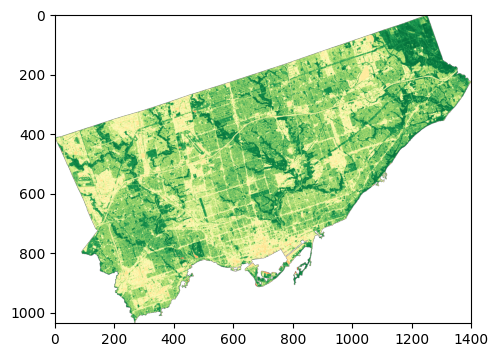

<Axes: >

In [8]:
#Quick Visualization
from rasterio.plot import show
import matplotlib.pyplot as plt

with rasterio.open('NDVI_RASTER/TORONTO_NDVI_MAY_AUG_2025.tif') as src:
    ndvi = src.read(1)
plt.figure(figsize=(6, 4))
show(ndvi, cmap='RdYlGn')

In [9]:
# NDVI STATISTICS
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from rasterio.plot import show

#  LOAD NDVI RASTER
ndvi_file = 'NDVI_RASTER/TORONTO_NDVI_MAY_AUG_2025.tif'

with rasterio.open(ndvi_file) as src:
    # Read the data
    ndvi = src.read(1)
    
    print("NDVI Raster Info:")
    print("-"*60)
    print(f"Resolution: {src.res}")
    print(f"Shape: {src.shape} (height x width)")
    print(f"CRS: {src.crs}")
    print(f"Bounds: {src.bounds}")
    print(f"NoData value: {src.nodata}")
    print("-"*60)

    # Handle nodata values
    if src.nodata is not None:
        ndvi_masked = np.ma.masked_equal(ndvi, src.nodata)
    else:
        ndvi_masked = np.ma.masked_invalid(ndvi)
    
    # Statistics
    print(f"\n")
    print("NDVI Statistics")
    print("-"*60)
    print(f"Min:    {ndvi_masked.min():.4f}")
    print(f"Max:    {ndvi_masked.max():.4f}")
    print(f"Mean:   {ndvi_masked.mean():.4f}")
    print(f"Median: {np.ma.median(ndvi_masked):.4f}")
    print(f"Std:    {ndvi_masked.std():.4f}")
    print(f"Valid pixels: {ndvi_masked.count():,}")
    print(f"No data pixels: {ndvi_masked.mask.sum():,}")
    print("-"*60)

NDVI Raster Info:
------------------------------------------------------------
Resolution: (30.0, 30.0)
Shape: (1036, 1401) (height x width)
CRS: EPSG:26917
Bounds: BoundingBox(left=609540.0, bottom=4826370.0, right=651570.0, top=4857450.0)
NoData value: None
------------------------------------------------------------


NDVI Statistics
------------------------------------------------------------
Min:    -0.5083
Max:    0.9072
Mean:   0.4995
Median: 0.5093
Std:    0.2145
Valid pixels: 708,075
No data pixels: 743,361
------------------------------------------------------------


### <font color='#A7C080'><div style="text-align:center;">PART 3: ZONAL STATISTICS </font>

In [10]:
#Loading Toronto Census Tract Shapefile

os.environ["SHAPE_RESTORE_SHX"] = "YES"         # fix for shapefile reading issues
census_gdf = gpd.read_file('shapefiles/Toronto_ct/TORONTO_CT_profiles.shp')
print(f"Original CRS: {census_gdf.crs}")

# Reproject to match mosaics (EPSG:32617)
census_gdf = census_gdf.to_crs('EPSG:32617')
print(f"Reprojected CRS: {census_gdf.crs}")

geometries = census_gdf.geometry.values
tract_ids = census_gdf['CTUID'].values  

print(f"Number of tracts: {len(census_gdf)}")
print(f"Columns: {census_gdf.columns.tolist()}")


Original CRS: EPSG:26917
Reprojected CRS: EPSG:32617
Number of tracts: 582
Columns: ['CTUID', 'DGUID', 'CTNAME', 'LANDAREA', 'PRUID', 'CTUID_', 'GEOUID', 'CMA', 'CTNAME_1', 'POPULATION', 'POPDEN', 'INCOME', 'MNRTY', 'OWNER', 'RENTER', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 'geometry']


In [11]:
'''

--- TEMPERATURE ZONAL STATISTICS ---
- This cell extracts zonal statistics from the thermal mosaics
- and adds them to the census tract GeoDataFrame.

'''

# MTL COEFFICIENTS FOR TEMPERATURE CONVERSION
TEMP_MULT = 0.00341802      #From Landsat 8/9 documentation
TEMP_ADD = 149.0            #From Landsat 8/9 documentation

mosaic_files = {
    'may': 'mosaics/B10_MOSAIC_TORONTO_MAY.TIF',
    'june': 'mosaics/B10_MOSAIC_TORONTO_JUNE.TIF',
    'july': 'mosaics/B10_MOSAIC_TORONTO_JULY.TIF',
    'august': 'mosaics/B10_MOSAIC_TORONTO_AUGUST.TIF'
}

results = pd.DataFrame({'CTUID': tract_ids})            # Initialize results DataFrame

for month, mosaic_file in mosaic_files.items():         # Loop through each month's mosaic
    print(f"{'-'*70}")
    print(f"Processing {month.upper()}")
    print(f"{'-'*70}")
    
    with rasterio.open(mosaic_file) as src:
        print(f"CRS: {src.crs}")
        print(f"Shape: {src.shape}")
        
        # Load DN values as float for calculations
        mosaic_dn = src.read(1).astype(float)   
      
        # GET THE AFFINE TRANSFORM
        affine = src.transform          # affine is the spatial reference for zonal stats
    
    print(f"DN range: {np.nanmin(mosaic_dn):.0f} to {np.nanmax(mosaic_dn):.0f}")
    
    # Convert DN to Kelvin
    temp_k = mosaic_dn * TEMP_MULT + TEMP_ADD    
    
    # Convert Kelvin to Celsius
    temp_c = temp_k - 273.15
    
    print(f"Temp (C) range: {np.nanmin(temp_c):.2f} to {np.nanmax(temp_c):.2f}")
    
    # [IMPORTANT] Mask invalid values
    temp_c[mosaic_dn == 0] = np.nan          # Nodata
    temp_c[temp_c < 0] = np.nan              # Too cold
    temp_c[temp_c > 60] = np.nan             # Too hot
    
    print(f"Valid pixels: {np.sum(~np.isnan(temp_c)):,}")
    
    # Extract zonal statistics
    stats = zonal_stats(geometries, temp_c, affine=affine, stats=['mean', 'std', 'min', 'max', 'count'], nodata=np.nan) 
    results[f'temp_{month}_mean'] = [s['mean'] for s in stats]
    results[f'temp_{month}_std'] = [s['std'] for s in stats]
    results[f'temp_{month}_min'] = [s['min'] for s in stats]
    results[f'temp_{month}_max'] = [s['max'] for s in stats]

----------------------------------------------------------------------
Processing MAY
----------------------------------------------------------------------
CRS: EPSG:32617
Shape: (1037, 1401)
DN range: 0 to 47243
Temp (C) range: -124.15 to 37.33
Valid pixels: 518,315
----------------------------------------------------------------------
Processing JUNE
----------------------------------------------------------------------
CRS: EPSG:32617
Shape: (1037, 1401)
DN range: 0 to 53036
Temp (C) range: -124.15 to 57.13
Valid pixels: 519,078
----------------------------------------------------------------------
Processing JULY
----------------------------------------------------------------------
CRS: EPSG:32617
Shape: (1037, 1401)
DN range: 0 to 53159
Temp (C) range: -124.15 to 57.55
Valid pixels: 518,959
----------------------------------------------------------------------
Processing AUGUST
----------------------------------------------------------------------
CRS: EPSG:32617
Shape: (1037, 1

In [14]:
# Reload census shapefile --IT KEPT GIVING ERROR UNLESS I DID THIS
census_gdf = gpd.read_file('shapefiles/Toronto_ct/TORONTO_CT_profiles.shp')
census_gdf = census_gdf.to_crs('EPSG:32617')

# Merge with results
census_gdf = census_gdf.merge(results, left_on='CTUID', right_on='CTUID', how='left')

# Rename and save
census_gdf = census_gdf.rename(columns={
    'temp_may_mean': 't_may',
    'temp_june_mean': 't_june',
    'temp_july_mean': 't_july',
    'temp_august_mean': 't_aug',
})
census_gdf.to_file('shapefiles/Toronto_ct/TORONTO_CT_with_temps.gpkg', driver='GPKG')

gdf = gpd.read_file("shapefiles/Toronto_ct/TORONTO_CT_with_temps.gpkg")

# Average summer temperature
gdf["avg_sumr"] = gdf[["t_may", "t_june", "t_july", "t_aug"]].mean(axis=1)

# Warming from May to August
gdf["warming"] = gdf["t_aug"] - gdf["t_may"]

# Save back to file
gdf.to_file("shapefiles/Toronto_ct/TORONTO_CT_with_temps.gpkg", driver="GPKG")

In [15]:
'''
--- NDVI ZONAL STATISTICS ---
- This cell extracts zonal statistics from the NDVI raster
- and adds them to the census tract GeoDataFrame.
'''


# Loading NDVI raster
ndvi_file = 'NDVI_RASTER/TORONTO_NDVI_MAY_AUG_2025.tif'

with rasterio.open(ndvi_file) as src:
    ndvi_data = src.read(1).astype(float)
    affine = src.transform
    print(f"NDVI CRS: {src.crs}")
    print(f"NDVI range: {np.nanmin(ndvi_data):.3f} to {np.nanmax(ndvi_data):.3f}")

# Extract zonal statistics
geometries = census_gdf.geometry.values
ndvi_stats = zonal_stats(geometries, ndvi_data, affine=affine, stats=['mean', 'std', 'min', 'max'], nodata=np.nan)

# Add to GeoDataFrame
census_gdf['ndvi_mean'] = [s['mean'] for s in ndvi_stats]
census_gdf['ndvi_std'] = [s['std'] for s in ndvi_stats]
census_gdf['ndvi_min'] = [s['min'] for s in ndvi_stats]
census_gdf['ndvi_max'] = [s['max'] for s in ndvi_stats]

# Save updated GeoDataFrame
gdf = gpd.read_file('shapefiles/Toronto_ct/TORONTO_CT_with_temps.gpkg')
gdf = gdf.merge(census_gdf[['CTUID', 'ndvi_mean', 'ndvi_std', 'ndvi_min', 'ndvi_max']], on='CTUID', how='left')
print(f"Shape: {gdf.shape}")
print(gdf[['CTUID', 'ndvi_mean', 'ndvi_std']].head())


NDVI CRS: EPSG:26917
NDVI range: -0.508 to 0.907
Shape: (582, 41)
        CTUID  ndvi_mean  ndvi_std
0  5350128.04   0.360703  0.140008
1  5350363.06   0.317469  0.170510
2  5350363.07   0.475023  0.234173
3  5350378.23   0.444746  0.183756
4  5350378.24   0.296124  0.196280


In [16]:
'''
--- SPATIAL INTERPOLATION FOR MISSING TEMPERATURE DATA ---
- This cell fills missing temperature values in the census tract GeoDataFrame   
'''

# Spatial Interpolation Function
def spatial_fill_nearest_neighbors(gdf, column, n_neighbors=3):
    """Fill missing values with mean of n nearest neighbors"""
    
    missing_idx = gdf[gdf[column].isna()].index
    for idx in missing_idx:
        # Get centroid of missing tract
        geom = gdf.loc[idx, 'geometry'].centroid
        
        # Calculate distances to all other tracts
        distances = gdf.geometry.centroid.distance(geom)
        
        # Find n+1 nearest (including self), then exclude self
        nearest = distances.nsmallest(n_neighbors + 1).index[1:n_neighbors + 1]
        
        # Fill with mean of neighbors
        neighbor_mean = gdf.loc[nearest, column].mean()
        gdf.loc[idx, column] = neighbor_mean
    
    return gdf

# Fill Each Temperature Column
temp_cols = ['t_may', 't_june', 't_july', 't_aug']

for col in temp_cols:
    if gdf[col].isnull().sum() > 0:
        gdf = spatial_fill_nearest_neighbors(gdf, col, n_neighbors=3)

# Verify
print("VERIFICATION")
print(f"{'-'*70}")

print("Missing values AFTER spatial fill:")
print(gdf[['t_may', 't_june', 't_july', 't_aug', 'ndvi_mean']].isnull().sum())

# Save Updated GeoPackage
gdf.to_file('shapefiles/Toronto_ct/TORONTO_CT_with_temps.gpkg', driver='GPKG')

print(f"  Total tracts: {len(gdf)}")
print(f"  Complete records: {len(gdf.dropna(subset=['t_may', 't_june', 't_july', 't_aug', 'ndvi_mean']))}")
# Check temperature ranges
print("\nTemperature ranges:")
print(f"  May:    {gdf['t_may'].min():.2f} to {gdf['t_may'].max():.2f}°C")
print(f"  June:   {gdf['t_june'].min():.2f} to {gdf['t_june'].max():.2f}°C")
print(f"  July:   {gdf['t_july'].min():.2f} to {gdf['t_july'].max():.2f}°C")
print(f"  August: {gdf['t_aug'].min():.2f} to {gdf['t_aug'].max():.2f}°C")

# Check NDVI range
print(f"\nNDVI: {gdf['ndvi_mean'].min():.3f} to {gdf['ndvi_mean'].max():.3f}")

# Check warming
print(f"\nWarming (May to Aug): {gdf['warming'].min():.2f} to {gdf['warming'].max():.2f}°C")

VERIFICATION
----------------------------------------------------------------------
Missing values AFTER spatial fill:
t_may        0
t_june       0
t_july       0
t_aug        0
ndvi_mean    0
dtype: int64
  Total tracts: 582
  Complete records: 582

Temperature ranges:
  May:    3.45 to 31.27°C
  June:   20.03 to 53.00°C
  July:   9.29 to 46.57°C
  August: 20.04 to 42.80°C

NDVI: 0.123 to 0.752

Warming (May to Aug): -5.05 to 32.73°C


In [17]:
# Recompute and save after spatial filling
gdf["avg_sumr"] = gdf[["t_may", "t_june", "t_july", "t_aug"]].mean(axis=1)
gdf["warming"] = gdf["t_aug"] - gdf["t_may"]
gdf.to_file("shapefiles/Toronto_ct/TORONTO_CT_with_temps.gpkg", driver="GPKG")
gdf.to_file("shapefiles/Toronto_ct/TORONTO_CT_with_temps.shp", driver="ESRI Shapefile")

C:\Users\snes_\AppData\Local\Temp\ipykernel_10528\3611148198.py:5: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("shapefiles/Toronto_ct/TORONTO_CT_with_temps.shp", driver="ESRI Shapefile")
c:\Users\snes_\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:733: RuntimeWarning: Normalized/laundered field name: 'temp_may_std' to 'temp_may_s'
  ogr_write(
c:\Users\snes_\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:733: RuntimeWarning: Normalized/laundered field name: 'temp_may_min' to 'temp_may_m'
  ogr_write(
c:\Users\snes_\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:733: RuntimeWarning: Normalized/laundered field name: 'temp_may_max' to 'temp_may_1'
  ogr_write(
c:\Users\snes_\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyogrio\raw.py:733: RuntimeWarning: Normalized/laundered field name: 'temp_june_std' to 'temp_june_'
  ogr_write

Index(['CTUID', 'DGUID', 'CTNAME', 'LANDAREA', 'PRUID', 'CTUID_', 'GEOUID',
       'CMA', 'CTNAME_1', 'POPULATION', 'POPDEN', 'INCOME', 'MNRTY', 'OWNER',
       'RENTER', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 't_may',
       'temp_may_std', 'temp_may_min', 'temp_may_max', 't_june',
       'temp_june_std', 'temp_june_min', 'temp_june_max', 't_july',
       'temp_july_std', 'temp_july_min', 'temp_july_max', 't_aug',
       'temp_august_std', 'temp_august_min', 'temp_august_max', 'avg_sumr',
       'warming', 'ndvi_mean', 'ndvi_std', 'ndvi_min', 'ndvi_max', 'geometry'],
      dtype='object')
Shape: (582, 41)
        CTUID      t_may     t_june     t_july      t_aug  ndvi_mean
0  5350128.04  16.521046  42.360235  39.244391  34.171875   0.360703
1  5350363.06  22.340984  41.389163  43.954335  37.836809   0.317469
2  5350363.07  19.531109  43.888556  39.196249  34.082970   0.475023
3  5350378.23  24.562388  34.676630  43.276971  38.561446   0.444746
4  5350378.24  25.465818  46.672369  3

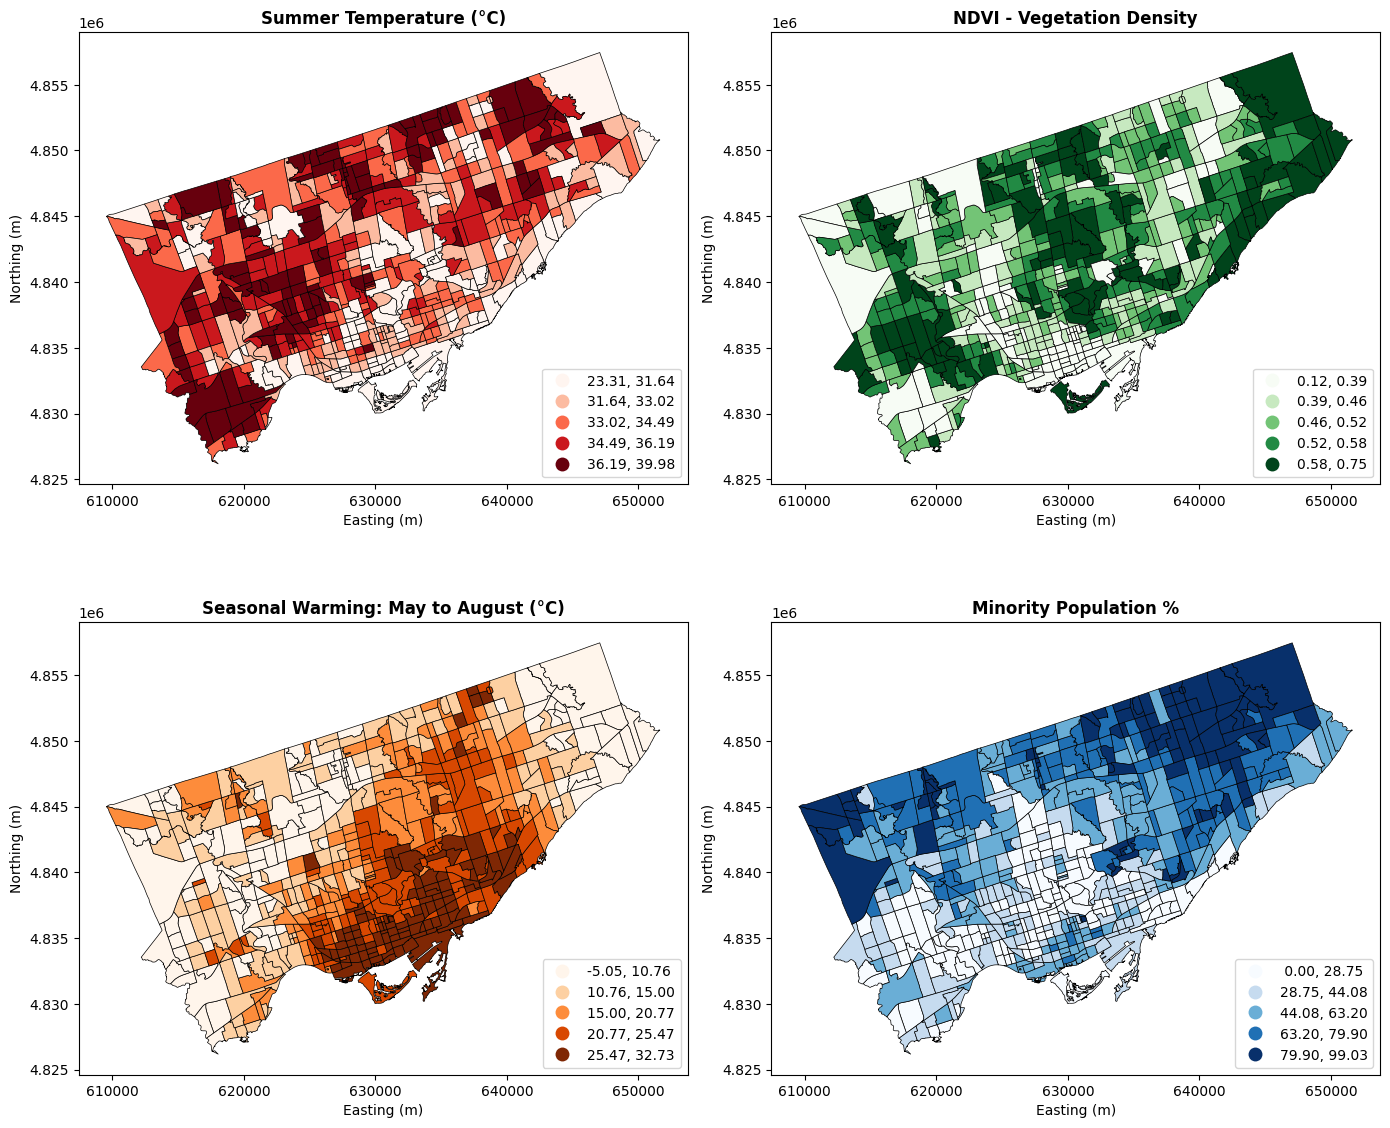

In [18]:
# FINAL VERIFICATION
gdf = gpd.read_file('shapefiles/Toronto_ct/TORONTO_CT_with_temps.gpkg')
print(gdf.columns)
print(f"Shape: {gdf.shape}")
print(gdf[['CTUID', 't_may', 't_june', 't_july', 't_aug', 'ndvi_mean']].head())


#--- VISUALIZATION OF CENSUS TRACT DATA ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
census_gdf = gdf.to_crs('EPSG:32617')

# Plot 1: Summer Temperature 
census_gdf.plot(
    column='avg_sumr', 
    ax=axes[0, 0],  
    cmap='Reds', 
    edgecolor='black', 
    linewidth=0.5,
    scheme='quantiles',
    legend=True,
    k=5
)
axes[0, 0].set_title('Summer Temperature (°C)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Easting (m)')
axes[0, 0].set_ylabel('Northing (m)')

# Plot 2: NDVI
census_gdf.plot(
    column='ndvi_mean', 
    ax=axes[0, 1],  
    cmap='Greens', 
    edgecolor='black', 
    linewidth=0.5,
    scheme='quantiles',
    legend=True,
    k=5
)
axes[0, 1].set_title('NDVI - Vegetation Density', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Easting (m)')
axes[0, 1].set_ylabel('Northing (m)')

# Plot 3: Warming 
census_gdf['warming'] = census_gdf['t_aug'] - census_gdf['t_may']
census_gdf.plot(
    column='warming', 
    cmap='Oranges',
    ax=axes[1, 0],  
    edgecolor='black', 
    linewidth=0.5,
    scheme='quantiles',
    legend=True,
    k=5
)
axes[1, 0].set_title('Seasonal Warming: May to August (°C)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Easting (m)')
axes[1, 0].set_ylabel('Northing (m)')

# Plot 4: Minority % 
census_gdf['minority_density'] = census_gdf['MNRTY'] / (census_gdf['Shape_Area']/1e6)
census_gdf['minority_percent'] = (census_gdf['MNRTY'] / census_gdf['POPULATION']) * 100

census_gdf.plot(
    column='minority_percent', 
    ax=axes[1, 1],  
    cmap='Blues', 
    edgecolor='black', 
    linewidth=0.5,
    scheme='natural_breaks',
    legend=True,
    k=5
)
axes[1, 1].set_title('Minority Population %', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Easting (m)')
axes[1, 1].set_ylabel('Northing (m)')

plt.tight_layout()
for ax in axes.flat:
    legend = ax.get_legend()
    if legend:
        legend.set_bbox_to_anchor((1.0, 0.0))
        legend.set_loc('lower right')

census_gdf.to_file('shapefiles/Toronto_ct/Census_full.gpkg', driver='GPKG')
plt.savefig('figures/toronto_census_tracts_overview.png', dpi=300, bbox_inches='tight')
plt.show()

### <font color='#A7C080'><div style="text-align:center;">PART 4 : STATISTICAL ANALYSIS </font>

In [19]:
# Loading the file created above
gdf = gpd.read_file(join("shapefiles", "Toronto_ct", "Census_full.gpkg"))
print("COLUMNS:")
print(gdf.columns.tolist())

def rotated_geometry(g: GeoDataFrame) -> GeoDataFrame:
    centroid = g.union_all().centroid
    z = g.copy(deep=True)
    z["geometry"] = g["geometry"].apply(lambda geom: rotate(geom, -17, origin=centroid))
    return z

COLUMNS:
['CTUID', 'DGUID', 'CTNAME', 'LANDAREA', 'PRUID', 'CTUID_', 'GEOUID', 'CMA', 'CTNAME_1', 'POPULATION', 'POPDEN', 'INCOME', 'MNRTY', 'OWNER', 'RENTER', 'Shape_Leng', 'Shape_Le_1', 'Shape_Area', 't_may', 'temp_may_std', 'temp_may_min', 'temp_may_max', 't_june', 'temp_june_std', 'temp_june_min', 'temp_june_max', 't_july', 'temp_july_std', 'temp_july_min', 'temp_july_max', 't_aug', 'temp_august_std', 'temp_august_min', 'temp_august_max', 'avg_sumr', 'warming', 'ndvi_mean', 'ndvi_std', 'ndvi_min', 'ndvi_max', 'minority_density', 'minority_percent', 'geometry']


In [20]:
# DATA PREPARATION & VARIABLE DEFINITION
target_var   = 'avg_sumr'          # Dependent Variable (Y)
ndvi_var     = 'ndvi_mean'         # Independent Variable 1
income_var   = 'INCOME'            # Independent Variable 2
minority_var = 'minority_percent'  # Independent Variable 3

gdf['home_ownership_rate'] = (gdf['OWNER'] / (gdf['OWNER'] + gdf['RENTER'])) * 100
home_var = 'home_ownership_rate'   # Independent Variable 4

# WRITE BACK TO GEOPACKAGE
gdf.to_file(join("shapefiles", "Toronto_ct", "Census_full.gpkg"), driver="GPKG", layer='Census_full')

In [22]:

# GLOBAL SPATIAL AUTOCORRELATION (MORAN'S I)
# ---------------------------------------------------------
# Determines if high temperatures are clustered globally or random

# CREATE SPATIAL WEIGHTS MATRIX (QUEEN CONTIGUITY)
# 'Queen' includes all neighbors sharing a vertex or edge
w = libpysal.weights.Queen.from_dataframe(gdf)
w.transform = 'r'  # pyright: ignore[reportAttributeAccessIssue] # Row-standardized weights

# CALCULATE MORAN'S I
y = gdf[target_var].values
moran = Moran(y, w)

print(f"\n{'-'*60}")
print(f"GLOBAL MORAN'S I RESULTS ({target_var})")
print(f"{'-'*60}")
print(f"Moran's I Index: {moran.I:.4f}")
print(f"P-value: {moran.p_sim:.4f}")
if moran.p_sim < 0.05:
    print("RESULT: Significant spatial clustering detected.")
else:
    print("RESULT: No significant clustering (Random distribution).")


C:\Users\snes_\AppData\Local\Temp\ipykernel_10528\4287886609.py:7: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = libpysal.weights.Queen.from_dataframe(gdf)


('WARNING: ', 8, ' is an island (no neighbors)')

------------------------------------------------------------
GLOBAL MORAN'S I RESULTS (avg_sumr)
------------------------------------------------------------
Moran's I Index: 0.4761
P-value: 0.0010
RESULT: Significant spatial clustering detected.


In [23]:
# CORRELATION
# Pearson r to quantify linear relationships
cols_for_corr = [target_var, ndvi_var, minority_var, income_var, home_var]
col_names = ["Avg. Summer Temp", "NDVI", "Minority %", "Income", "Home Ownership %"]  # Better labels
corr_matrix = gdf[cols_for_corr].corr(method='pearson')

In [30]:
"""
Performs Getis-Ord Gi* Hot Spot Analysis to identify statistically significant spatial clusters.

NOTE:
Because the reference distribution is generated via random shuffling, 
the resulting simulated p-values ('p_sim') and Z-scores ('z_sim') may vary slightly between 
runs. This is a feature, not a bug, as it tests the observed pattern against randomized versions 
of the dataset.

"""

# LOAD DATA
gdf = gpd.read_file(join("shapefiles", "Toronto_ct", "Census_full.gpkg"))

# Variables
target_var = 'avg_sumr'  # Absolute Temp
warming_var = 'warming'  # Seasonal Heating (Aug - May)

# Clean NaNs
cols_to_check = [target_var, warming_var]
gdf = gdf.dropna(subset=cols_to_check)

# SPATIAL WEIGHTS (KNN)
# Using K-Nearest Neighbors (k=8)
w = libpysal.weights.KNN.from_dataframe(gdf, k=8)
w.transform = 'r'  # Row-standardized weights

# ANALYSIS A: ABSOLUTE HEAT ISLANDS (Standard Gi*)
# ---------------------------------------------------------
print(f"Running Getis-Ord Gi* on {target_var}...")

#permutations=9999 for more robust p-values
g_local = G_Local(gdf[target_var].values, w, transform='R', star=True, permutations=9999)
gdf['Z_Score'] = g_local.z_sim
gdf['P_Value'] = g_local.p_sim
gdf['is_hotspot'] = (gdf['Z_Score'] > 1.96) & (gdf['P_Value'] < 0.05)

# ANALYSIS B: SEASONAL WARMING HOT SPOTS
# ---------------------------------------------------------
print(f"Running Getis-Ord Gi* on {warming_var}...")
g_warming = G_Local(gdf[warming_var].values, w, transform='R', star=True, permutations=9999)
gdf['Z_Warming'] = g_warming.z_sim
gdf['P_Warming'] = g_warming.p_sim
gdf['is_warming_hotspot'] = (gdf['Z_Warming'] > 1.96) & (gdf['P_Warming'] < 0.05)

# Intersection of "Hot" and "Getting Hotter"
conditions = [
    (gdf['is_hotspot'] & gdf['is_warming_hotspot']),  # Case 1: Hot AND Warming Fast
    (gdf['is_hotspot'] & ~gdf['is_warming_hotspot']), # Case 2: Hot but Stable
    (~gdf['is_hotspot'] & gdf['is_warming_hotspot'])  # Case 3: Not hot yet, but Warming Fast
]
choices = ['Hot & Intensifying', 'Hot but Stable', 'Rapid Warming']
gdf['risk_category'] = np.select(conditions, choices, default='Low Risk')

print(f"\n{'-'*60}")
print(f"GETIS-ORD GI* HOT SPOT ANALYSIS RESULTS")
print(f"{'-'*60}")
print(f"Absolute Temperature Hot Spots:")
print(f"  Significant (p < 0.05): {(gdf['P_Value'] < 0.05).sum()} tracts")
print(f"  Very significant (p < 0.01): {(gdf['P_Value'] < 0.01).sum()} tracts")
print(f"  Highly significant (p < 0.001): {(gdf['P_Value'] < 0.001).sum()} tracts")
print(f"  Mean p-value: {gdf['P_Value'].mean():.4f}")
print(f"  Median p-value: {gdf['P_Value'].median():.4f}")

print(f"\nSeasonal Warming Hot Spots:")
print(f"  Significant (p < 0.05): {(gdf['P_Warming'] < 0.05).sum()} tracts")
print(f"  Very significant (p < 0.01): {(gdf['P_Warming'] < 0.01).sum()} tracts")
print(f"  Highly significant (p < 0.001): {(gdf['P_Warming'] < 0.001).sum()} tracts")
print(f"  Mean p-value: {gdf['P_Warming'].mean():.4f}")
print(f"  Median p-value: {gdf['P_Warming'].median():.4f}")

# Save back to file
gdf.to_file(join("shapefiles", "Toronto_ct", "Census_full.gpkg"), driver="GPKG", layer='Census_full', mode='w')
print("\nRISK CATEGORY COUNTS:")
print(gdf['risk_category'].value_counts())

Running Getis-Ord Gi* on avg_sumr...


c:\Users\snes_\AppData\Local\Programs\Python\Python312\Lib\site-packages\esda\getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)


Running Getis-Ord Gi* on warming...


c:\Users\snes_\AppData\Local\Programs\Python\Python312\Lib\site-packages\esda\getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)



------------------------------------------------------------
GETIS-ORD GI* HOT SPOT ANALYSIS RESULTS
------------------------------------------------------------
Absolute Temperature Hot Spots:
  Significant (p < 0.05): 243 tracts
  Very significant (p < 0.01): 144 tracts
  Highly significant (p < 0.001): 52 tracts
  Mean p-value: 0.1362
  Median p-value: 0.0800

Seasonal Warming Hot Spots:
  Significant (p < 0.05): 356 tracts
  Very significant (p < 0.01): 270 tracts
  Highly significant (p < 0.001): 144 tracts
  Mean p-value: 0.0922
  Median p-value: 0.0148

RISK CATEGORY COUNTS:
risk_category
Low Risk          306
Rapid Warming     163
Hot but Stable    113
Name: count, dtype: int64


In [31]:
# INTERNAL VARIANCE (COEFFICIENT OF VARIATION)
# Finds tracts with high internal temperature variability (pockets of heat)

# CV = Standard Deviation / Mean
gdf["avg_sumr_std"] = gdf[["t_may", "t_june", "t_july", "t_aug"]].std(axis=1)
gdf["temp_CV"] = gdf["avg_sumr_std"] / gdf["avg_sumr"]

print(f"\n{'-'*60}")
print("COEFFICIENT OF VARIATION (CV) STATS")
print(f"{'-'*60}")
print(gdf['temp_CV'].describe())

# Top 5 most variable tracts
print("\nTracts with highest internal temperature variance:")
print(gdf.nlargest(5, 'temp_CV')[['CTUID', 'temp_CV', 'ndvi_mean']])



------------------------------------------------------------
COEFFICIENT OF VARIATION (CV) STATS
------------------------------------------------------------
count    582.000000
mean       0.355636
std        0.114761
min        0.136921
25%        0.259717
50%        0.334642
75%        0.456717
max        0.630786
Name: temp_CV, dtype: float64

Tracts with highest internal temperature variance:
          CTUID   temp_CV  ndvi_mean
269  5350312.02  0.630786   0.587648
450  5350312.05  0.630315   0.393282
581  5350017.02  0.597192   0.262636
70   5350082.00  0.583675   0.484119
564  5350044.02  0.582704   0.281855


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import LineString
from scipy import stats
from os.path import join

def run_analysis():
    # ---------------------------------------------------------
    # 1. SETUP & DATA LOADING
    # ---------------------------------------------------------
    try:
        # Load data (Ensure path matches your local directory structure)
        gdf = gpd.read_file(join("shapefiles", "Toronto_ct", "Census_full.gpkg"))
    except Exception as e:
        print(f"Error loading data: {e}")
        return

    # Create Lake Ontario shoreline (Southern boundary approximation)
    shoreline_coords = [
        (-79.639, 43.588),  # West (Etobicoke)
        (-79.315, 43.641),  # East (Scarborough)
    ]
    shoreline = LineString(shoreline_coords)

    # Calculate distance from each census tract centroid to shoreline
    # (Projecting to match CRS for accurate distance, then converting to km)
    gdf['centroid'] = gdf.geometry.centroid
    gdf['dist_to_shore_km'] = gdf['centroid'].distance(
        gpd.GeoSeries([shoreline], crs='EPSG:4326').to_crs(gdf.crs)[0]
    ) / 1000 

    # ---------------------------------------------------------
    # 2. STANDARD ANALYSIS (Waterfront vs. Inland)
    # ---------------------------------------------------------
    
    # Categorize tracts
    gdf['shore_category'] = pd.cut(
        gdf['dist_to_shore_km'],
        bins=[0, 1, 5, np.inf],
        labels=['Waterfront (<1km)', 'Near Shore (1-5km)', 'Inland (>5km)']
    )

    print(f"\n{'='*70}")
    print("PART 1: LAKE ONTARIO COOLING EFFECT ANALYSIS (STANDARD)")
    print(f"{'='*70}\n")

    for category in ['Waterfront (<1km)', 'Near Shore (1-5km)', 'Inland (>5km)']:
        subset = gdf[gdf['shore_category'] == category]
        
        print(f"{category}:")
        print(f"  Number of tracts: {len(subset)}")
        # Check if subset is not empty to avoid errors
        if not subset.empty:
            print(f"  Mean Temperature: {subset['avg_sumr'].mean():.2f}°C (σ={subset['avg_sumr'].std():.2f}°C)")
            print(f"  Mean NDVI: {subset['ndvi_mean'].mean():.3f}")
            print(f"  Mean Warming (May-Aug): {subset['warming'].mean():.2f}°C")
        print()

    # Calculate temperature differential
    waterfront_temp = gdf[gdf['shore_category'] == 'Waterfront (<1km)']['avg_sumr'].mean()
    inland_temp = gdf[gdf['shore_category'] == 'Inland (>5km)']['avg_sumr'].mean()
    temp_diff = inland_temp - waterfront_temp

    print(f"{'='*70}")
    print(f"LAKE ONTARIO MODERATING EFFECT: {temp_diff:.2f}°C")
    print(f"{'='*70}\n")

    # Statistical test (t-test)
    waterfront_data = gdf[gdf['shore_category'] == 'Waterfront (<1km)']['avg_sumr'].dropna()
    inland_data = gdf[gdf['shore_category'] == 'Inland (>5km)']['avg_sumr'].dropna()

    t_stat, p_value = stats.ttest_ind(waterfront_data, inland_data)
    print(f"Statistical Significance (Standard T-Test):")
    print(f"  t-statistic: {t_stat:.3f}")
    print(f"  p-value: {p_value:.4f}")
    if p_value < 0.001:
        print(f"  Result: HIGHLY SIGNIFICANT difference (p < 0.001)")
    elif p_value < 0.05:
        print(f"  Result: Significant difference (p < 0.05)")
    else:
        print(f"  Result: No significant difference")


    # ---------------------------------------------------------
    # 3. REFINED ANALYSIS (Accounting for Heterogeneity)
    # ---------------------------------------------------------

    print(f"\n\n{'='*80}")
    print("PART 2: REFINED ANALYSIS")
    print("(Accounting for Waterfront Heterogeneity)")
    print(f"{'='*80}\n")

    # --- Analysis A: Compare STABLE areas only ---
    
    # Define comparison groups
    near_shore = gdf[(gdf['dist_to_shore_km'] >= 1) & (gdf['dist_to_shore_km'] < 3)]
    far_inland = gdf[gdf['dist_to_shore_km'] > 7]

    print("COMPARISON A: Near-Shore vs. Far Inland (Stable Areas Only)")
    print(f"{'-'*80}")
    
    print(f"Near Shore (1-3km):")
    print(f"  N = {len(near_shore)} tracts")
    if not near_shore.empty:
        print(f"  Mean Temp: {near_shore['avg_sumr'].mean():.2f}°C (σ={near_shore['avg_sumr'].std():.2f}°C)")
        print(f"  Mean NDVI: {near_shore['ndvi_mean'].mean():.3f}")
        print(f"  Mean Warming: {near_shore['warming'].mean():.2f}°C\n")

    print(f"Far Inland (>7km):")
    print(f"  N = {len(far_inland)} tracts")
    if not far_inland.empty:
        print(f"  Mean Temp: {far_inland['avg_sumr'].mean():.2f}°C (σ={far_inland['avg_sumr'].std():.2f}°C)")
        print(f"  Mean NDVI: {far_inland['ndvi_mean'].mean():.3f}")
        print(f"  Mean Warming: {far_inland['warming'].mean():.2f}°C\n")

    temp_diff_stable = far_inland['avg_sumr'].mean() - near_shore['avg_sumr'].mean()
    print(f"Temperature Differential: {temp_diff_stable:.2f}°C")
    print(f"(Inland is {temp_diff_stable:.2f}°C warmer than near-shore)")

    # Statistical test for Refined Analysis
    t_stat_refined, p_val_refined = stats.ttest_ind(
        near_shore['avg_sumr'].dropna(),
        far_inland['avg_sumr'].dropna()
    )
    print(f"\nStatistical Test (Refined):")
    print(f"  t-statistic: {t_stat_refined:.3f}")
    print(f"  p-value: {p_val_refined:.6f}")
    if p_val_refined < 0.001:
        print(f"  *** HIGHLY SIGNIFICANT (p < 0.001) ***")
    elif p_val_refined < 0.05:
        print(f"  ** SIGNIFICANT (p < 0.05) **")

    # --- Analysis B: Waterfront Internal Variance ---

    print(f"\n{'='*80}")
    print("ANALYSIS B: Waterfront Internal Variance")
    print(f"{'='*80}\n")

    waterfront = gdf[gdf['dist_to_shore_km'] < 1]

    if not waterfront.empty:
        print(f"Waterfront Tracts (<1km): N = {len(waterfront)}")
        print(f"  Mean Temperature: {waterfront['avg_sumr'].mean():.2f}°C")
        print(f"  Standard Deviation: {waterfront['avg_sumr'].std():.2f}°C")
        print(f"  Coefficient of Variation: {(waterfront['avg_sumr'].std()/waterfront['avg_sumr'].mean())*100:.1f}%")
        print(f"  Temperature Range: {waterfront['avg_sumr'].min():.2f}°C to {waterfront['avg_sumr'].max():.2f}°C")
        print(f"  Spread: {waterfront['avg_sumr'].max() - waterfront['avg_sumr'].min():.2f}°C\n")
    
    print("Interpretation of Variance:")
    print("  - Cool zones directly adjacent to water")
    print("  - Hot industrial corridors (Port Lands, highways)")
    print("  - Mixed land use within single census tracts")

    # --- Analysis C: Warming Gradient ---

    print(f"\n{'='*80}")
    print("ANALYSIS C: Seasonal Warming Gradient")
    print(f"{'='*80}\n")

    # Create detailed distance bins
    gdf['distance_bin'] = pd.cut(
        gdf['dist_to_shore_km'],
        bins=[0, 1, 2, 3, 5, 10, 20],
        labels=['<1km', '1-2km', '2-3km', '3-5km', '5-10km', '>10km']
    )

    warming_by_distance = gdf.groupby('distance_bin', observed=True).agg({
        'warming': ['mean', 'std', 'count'],
        'avg_sumr': 'mean'
    }).round(2)

    print("Warming Rate and Avg Temp by Distance from Shore:")
    print(warming_by_distance)
    print(f"\n{'='*80}")

if __name__ == "__main__":
    run_analysis()

In [32]:
'''
Please refer to the regression.py script for detailed regression analysis
'''
%run regression.py

Loaded 582 Census Tracts.
Rows before dropNA: 582
Rows after dropNA: 580

------------------------------------------------------------
ORDINARY LEAST SQUARES (OLS) REGRESSION
Dependent Variable (Y): avg_sumr
Independent Variables (X): NDVI, Minority %, Income, Home Ownership Rate
------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:               avg_sumr   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                  0.157
Method:                 Least Squares   F-statistic:                     27.93
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           3.23e-21
Time:                        19:26:50   Log-Likelihood:                -1339.4
No. Observations:                 580   AIC:                             2689.
Df Residuals:                     575   BIC:                             2711.
Df Model:                 

### <font color='#A7C080'><div style="text-align:center;">PART 5: VISUALIZATIONS </font>

         avg_sumr  avg_sumr_std     temp_cv
count  582.000000    582.000000  582.000000
mean    33.793769     11.837963    0.355636
std      2.664673      3.364357    0.114761
min     23.306194      4.564914    0.136921
25%     32.000919      9.193132    0.259717
50%     33.795557     11.562610    0.334642
75%     35.773984     14.573425    0.456717
max     39.978494     19.279993    0.630786
582 valid geometries


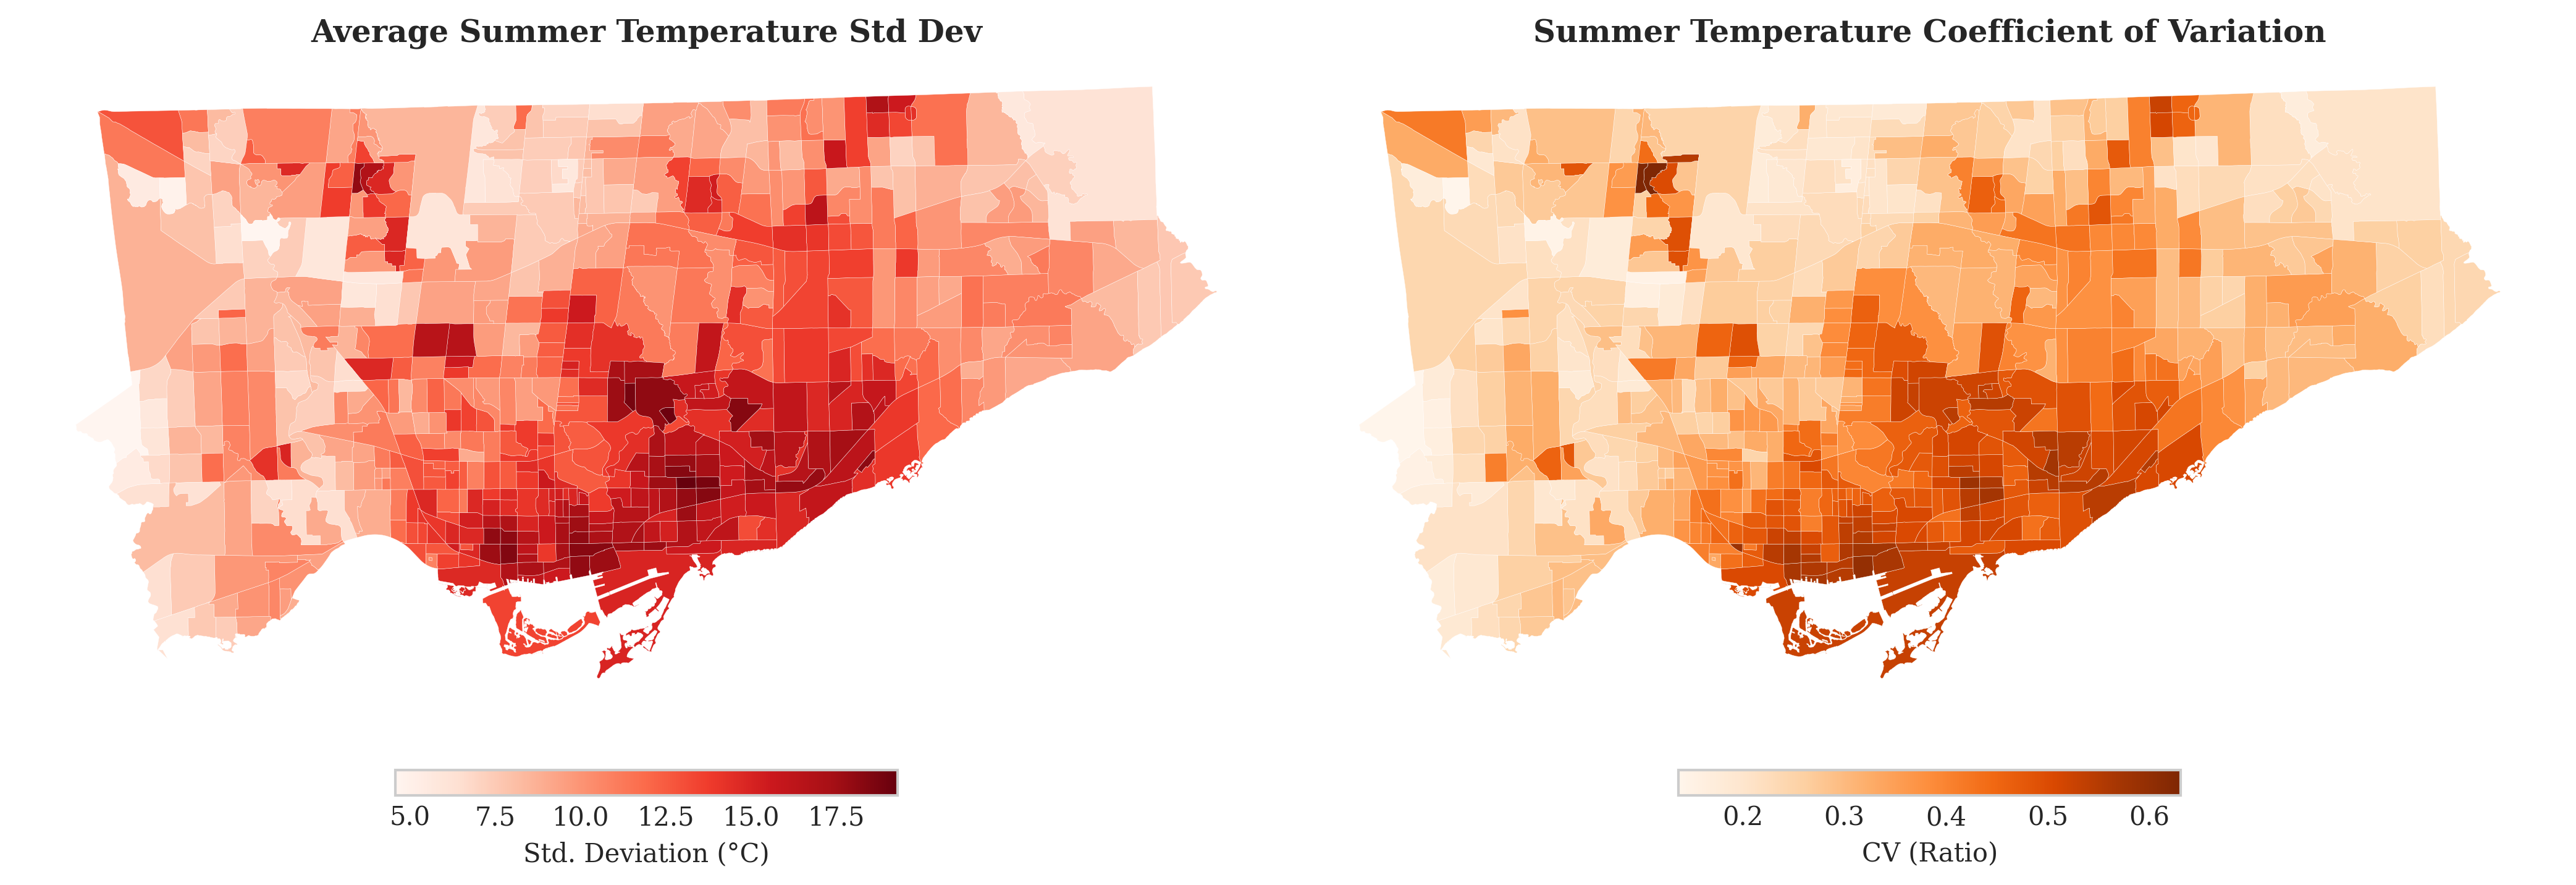

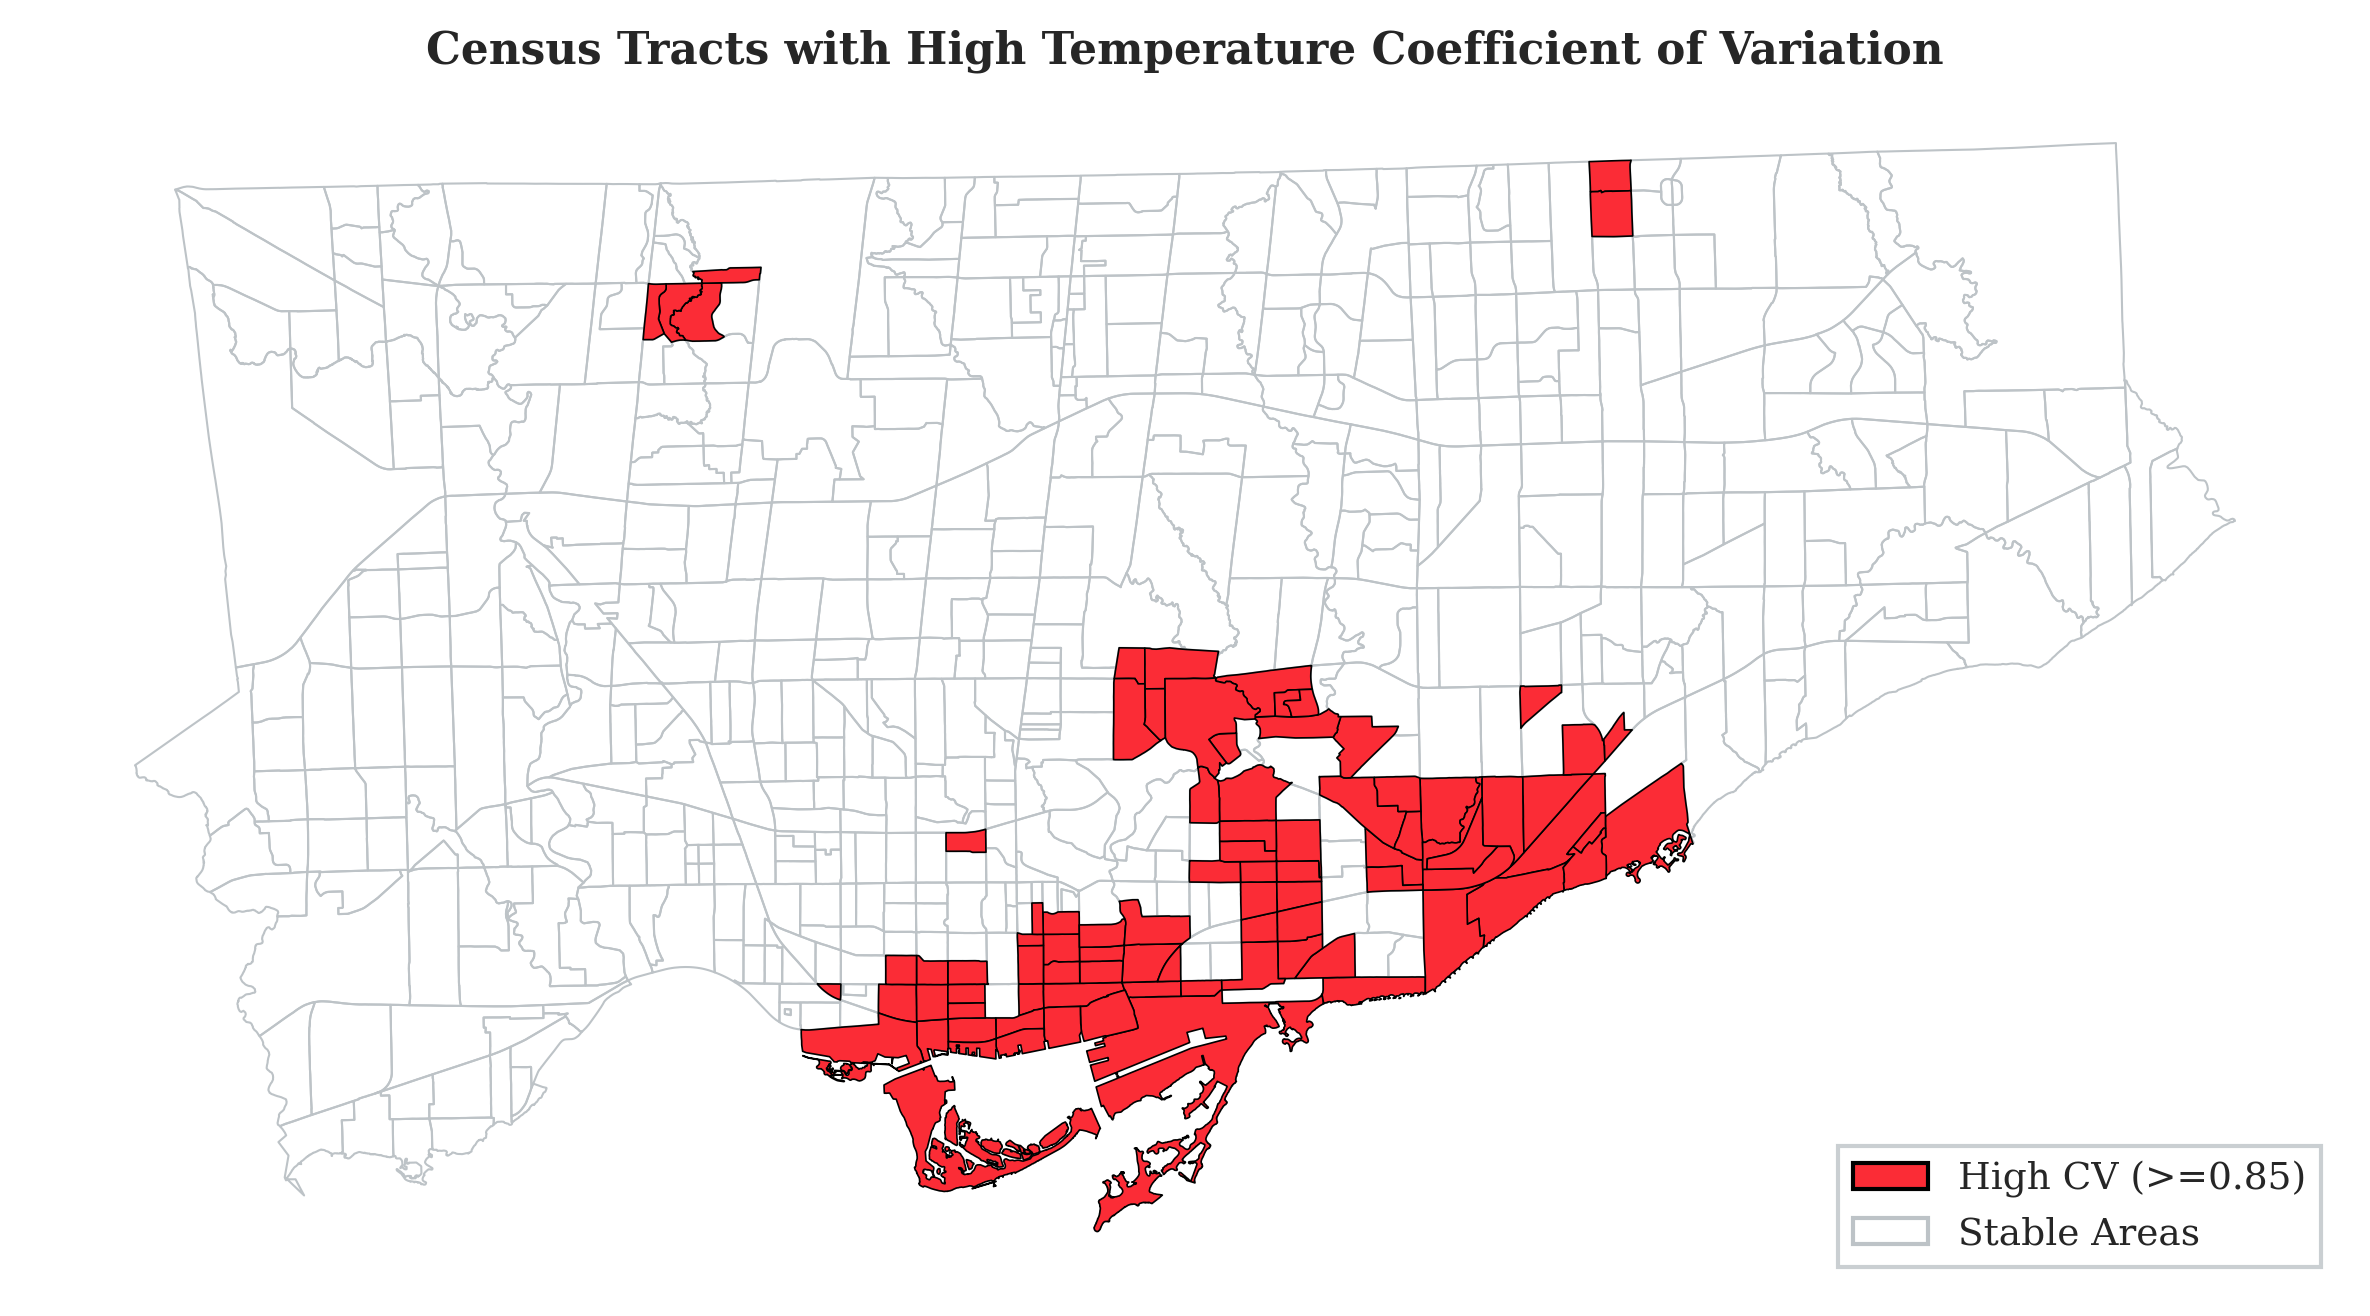

In [ ]:
# --- INTERNAL VARIANCE METRICS ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 300

# Average-summer standard deviation
gdf["avg_sumr_std"] = gdf[["t_may", "t_june", "t_july", "t_aug"]].std(axis=1)

# Coefficient of variation (CT-level thermal unevenness)
gdf["temp_cv"] = gdf["avg_sumr_std"] / gdf["avg_sumr"]
print(gdf[["avg_sumr", "avg_sumr_std", "temp_cv"]].describe())
print(gdf.geometry.is_valid.sum(), "valid geometries")

# Create a rotated copy for plotting
gdf_rotated = rotated_geometry(gdf)

# Set up figure
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
for z in ax.flat:
    z.set_axis_off()

# Plot 1: Average-summer standard deviation 
gdf_rotated.plot(
    column="avg_sumr_std",
    cmap="Reds",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    legend_kwds={"orientation": "horizontal", "shrink": 0.4, "pad": 0.05, "label": "Std. Deviation (°C)"},
    ax=ax[0]
)
ax[0].set_title("Average Summer Temperature Std Dev", fontweight='bold')

# Plot 2: Coefficient of Variation
gdf_rotated.plot(
    column="temp_cv",
    cmap="Oranges",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    legend_kwds={"orientation": "horizontal", "shrink": 0.4, "pad": 0.05, "label": "CV (Ratio)"},
    ax=ax[1],
)
ax[1].set_title("Summer Temperature Coefficient of Variation", fontweight='bold')

plt.tight_layout()
plt.show()


# --- PLOT 3: HIGH CV HIGHLIGHTS ---

# Pick a cutoff for high CV (using original data values)
cutoff = gdf["temp_cv"].quantile(0.85)

# Filter the ROTATED dataframe
# to make outlines (low_cv) and the fills (high_cv) fit together perfectly
high_cv_rot = gdf_rotated[gdf_rotated["temp_cv"] >= cutoff]
low_cv_rot = gdf_rotated[gdf_rotated["temp_cv"] < cutoff]

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Base layer: Stable areas (Low CV) as outlines
low_cv_rot.plot(
    color="none",
    edgecolor="#bdc3c7",
    linewidth=0.5,
    ax=ax
)

# Highlight layer: High CV tracts filled
high_cv_rot.plot(
    color="#FB2C36",
    edgecolor="black",
    linewidth=0.4,
    ax=ax
)

ax.set_title("Census Tracts with High Temperature Coefficient of Variation", fontsize=10.5, fontweight='bold')
ax.axis("off")

# custom legend
red_patch = mpatches.Patch(facecolor='#FB2C36', edgecolor='black', label='High CV (>=0.85)')
grey_patch = mpatches.Patch(facecolor='none', edgecolor='#bdc3c7', label='Stable Areas')
ax.legend(handles=[red_patch, grey_patch], loc='lower right', frameon=True, fancybox=False, edgecolor='#bdc3c7', fontsize=9)

plt.tight_layout()
plt.show()

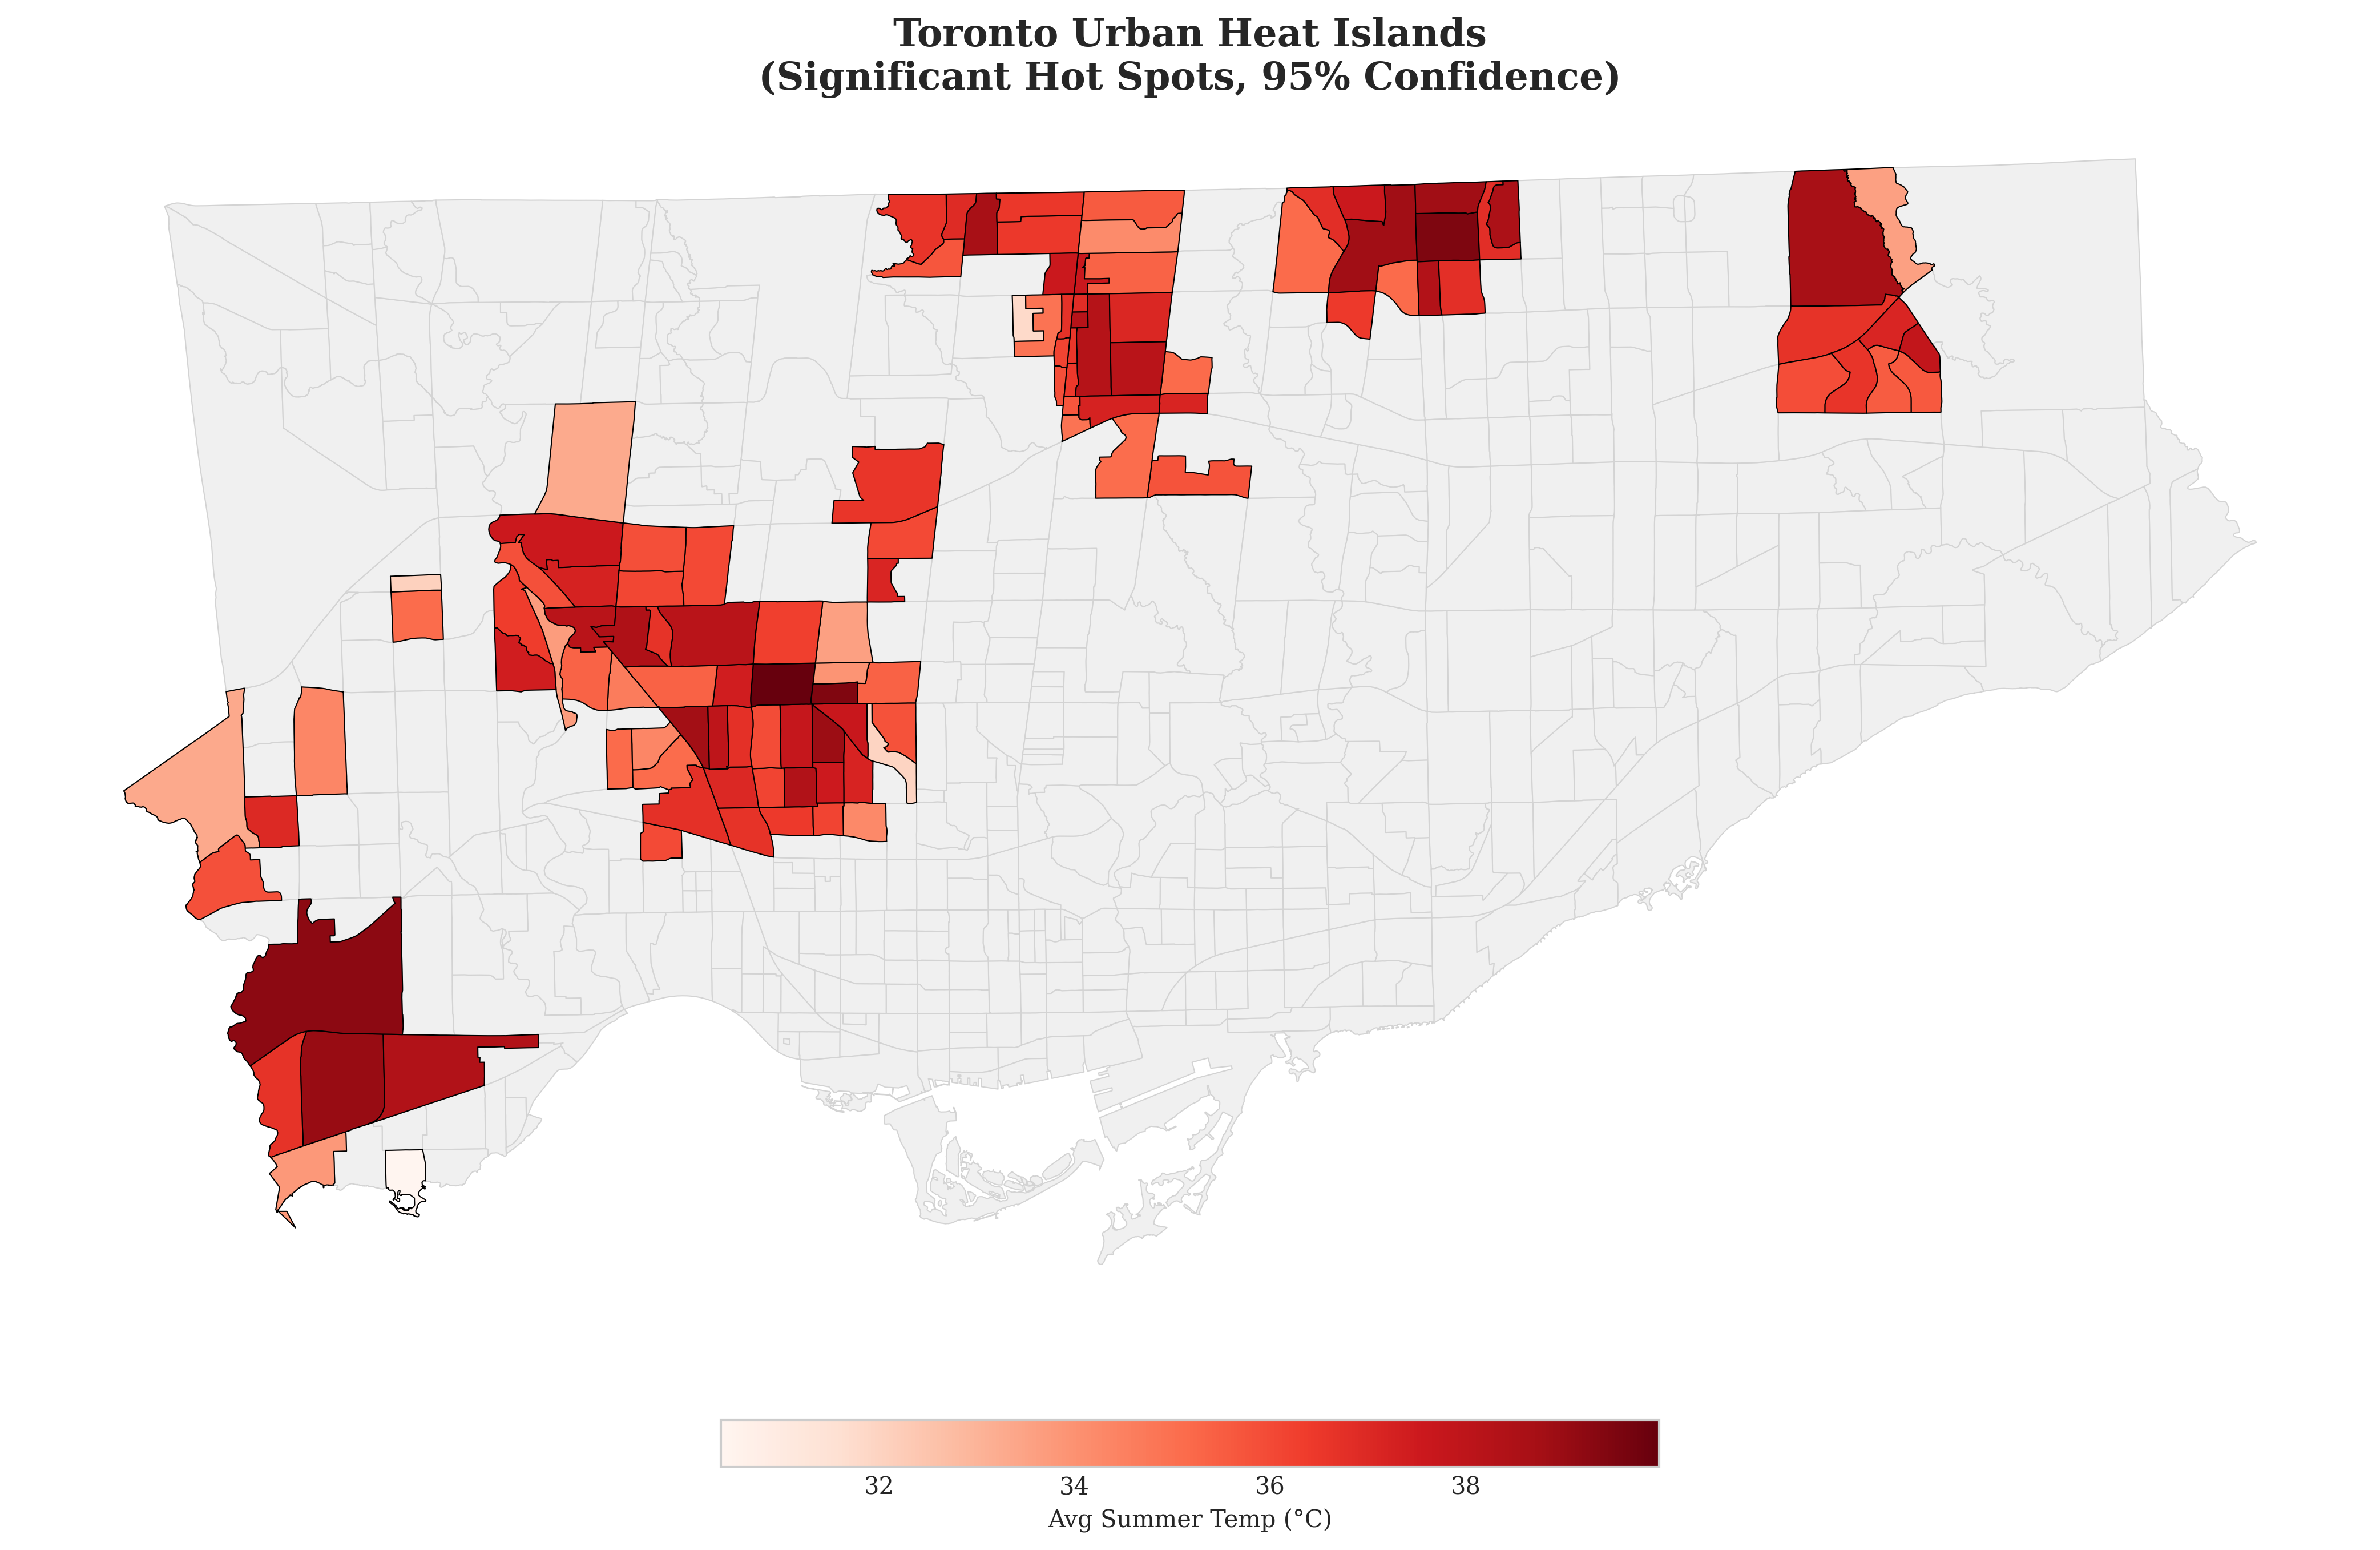

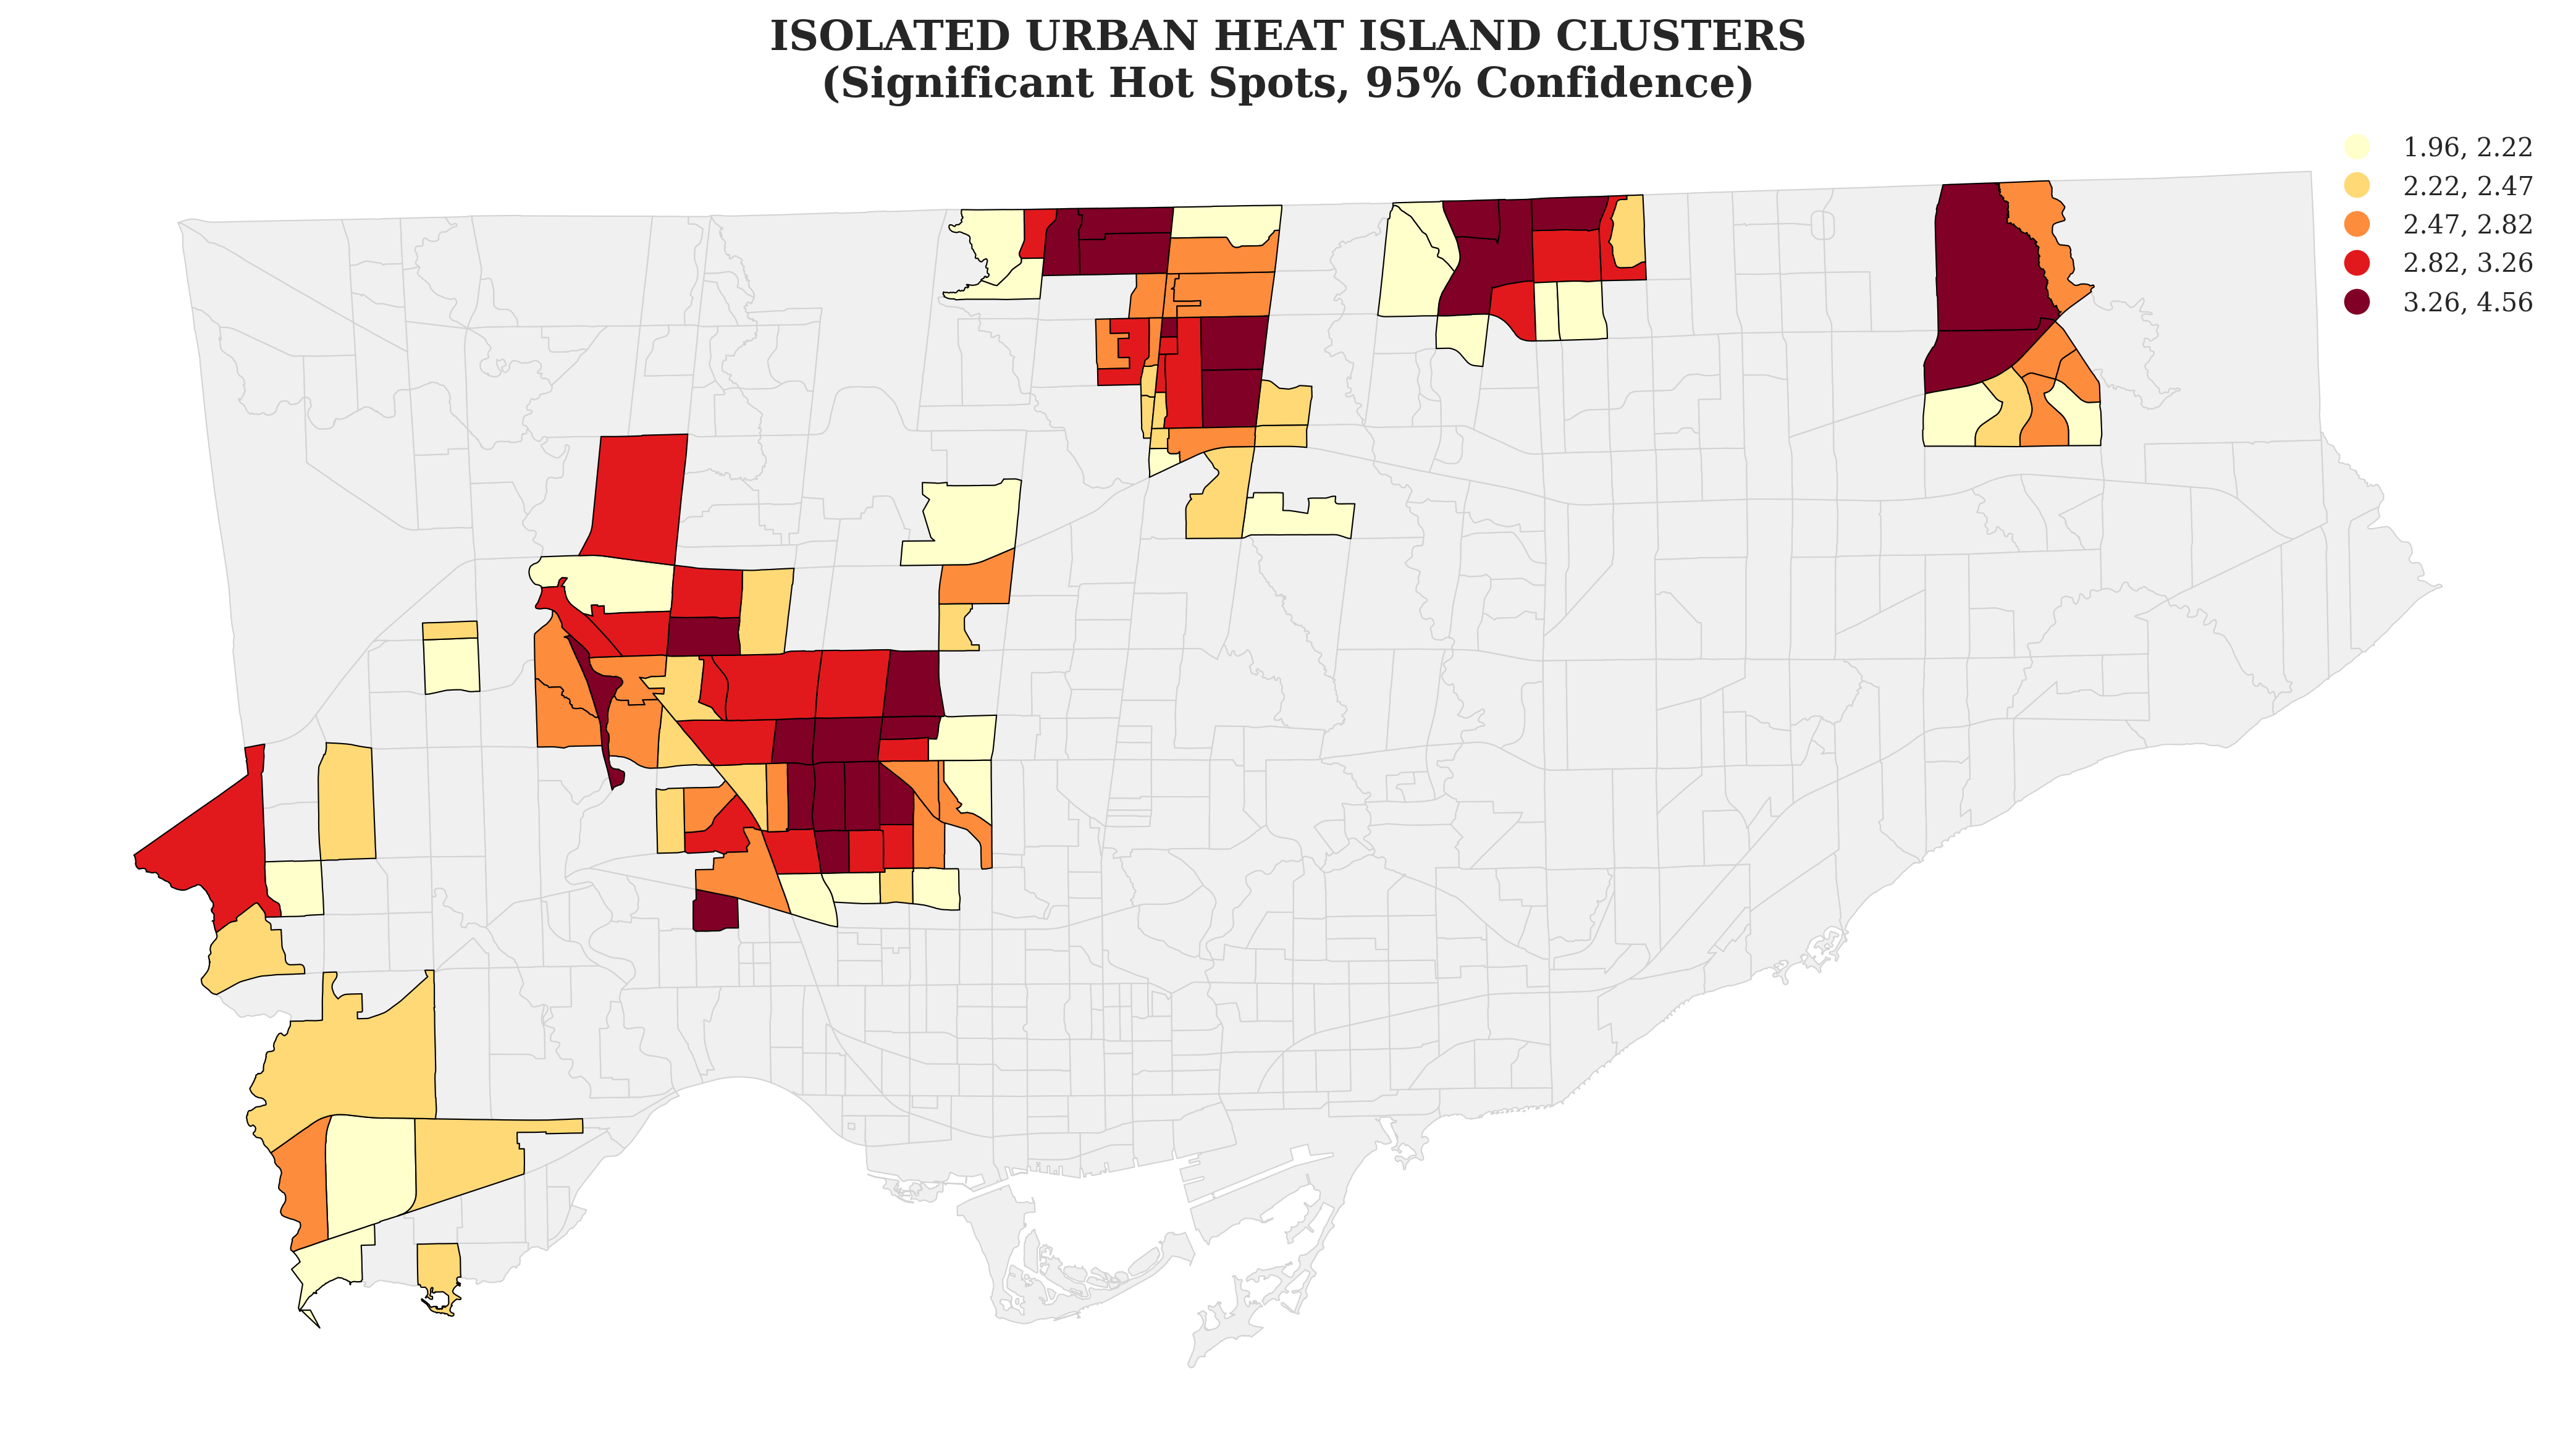

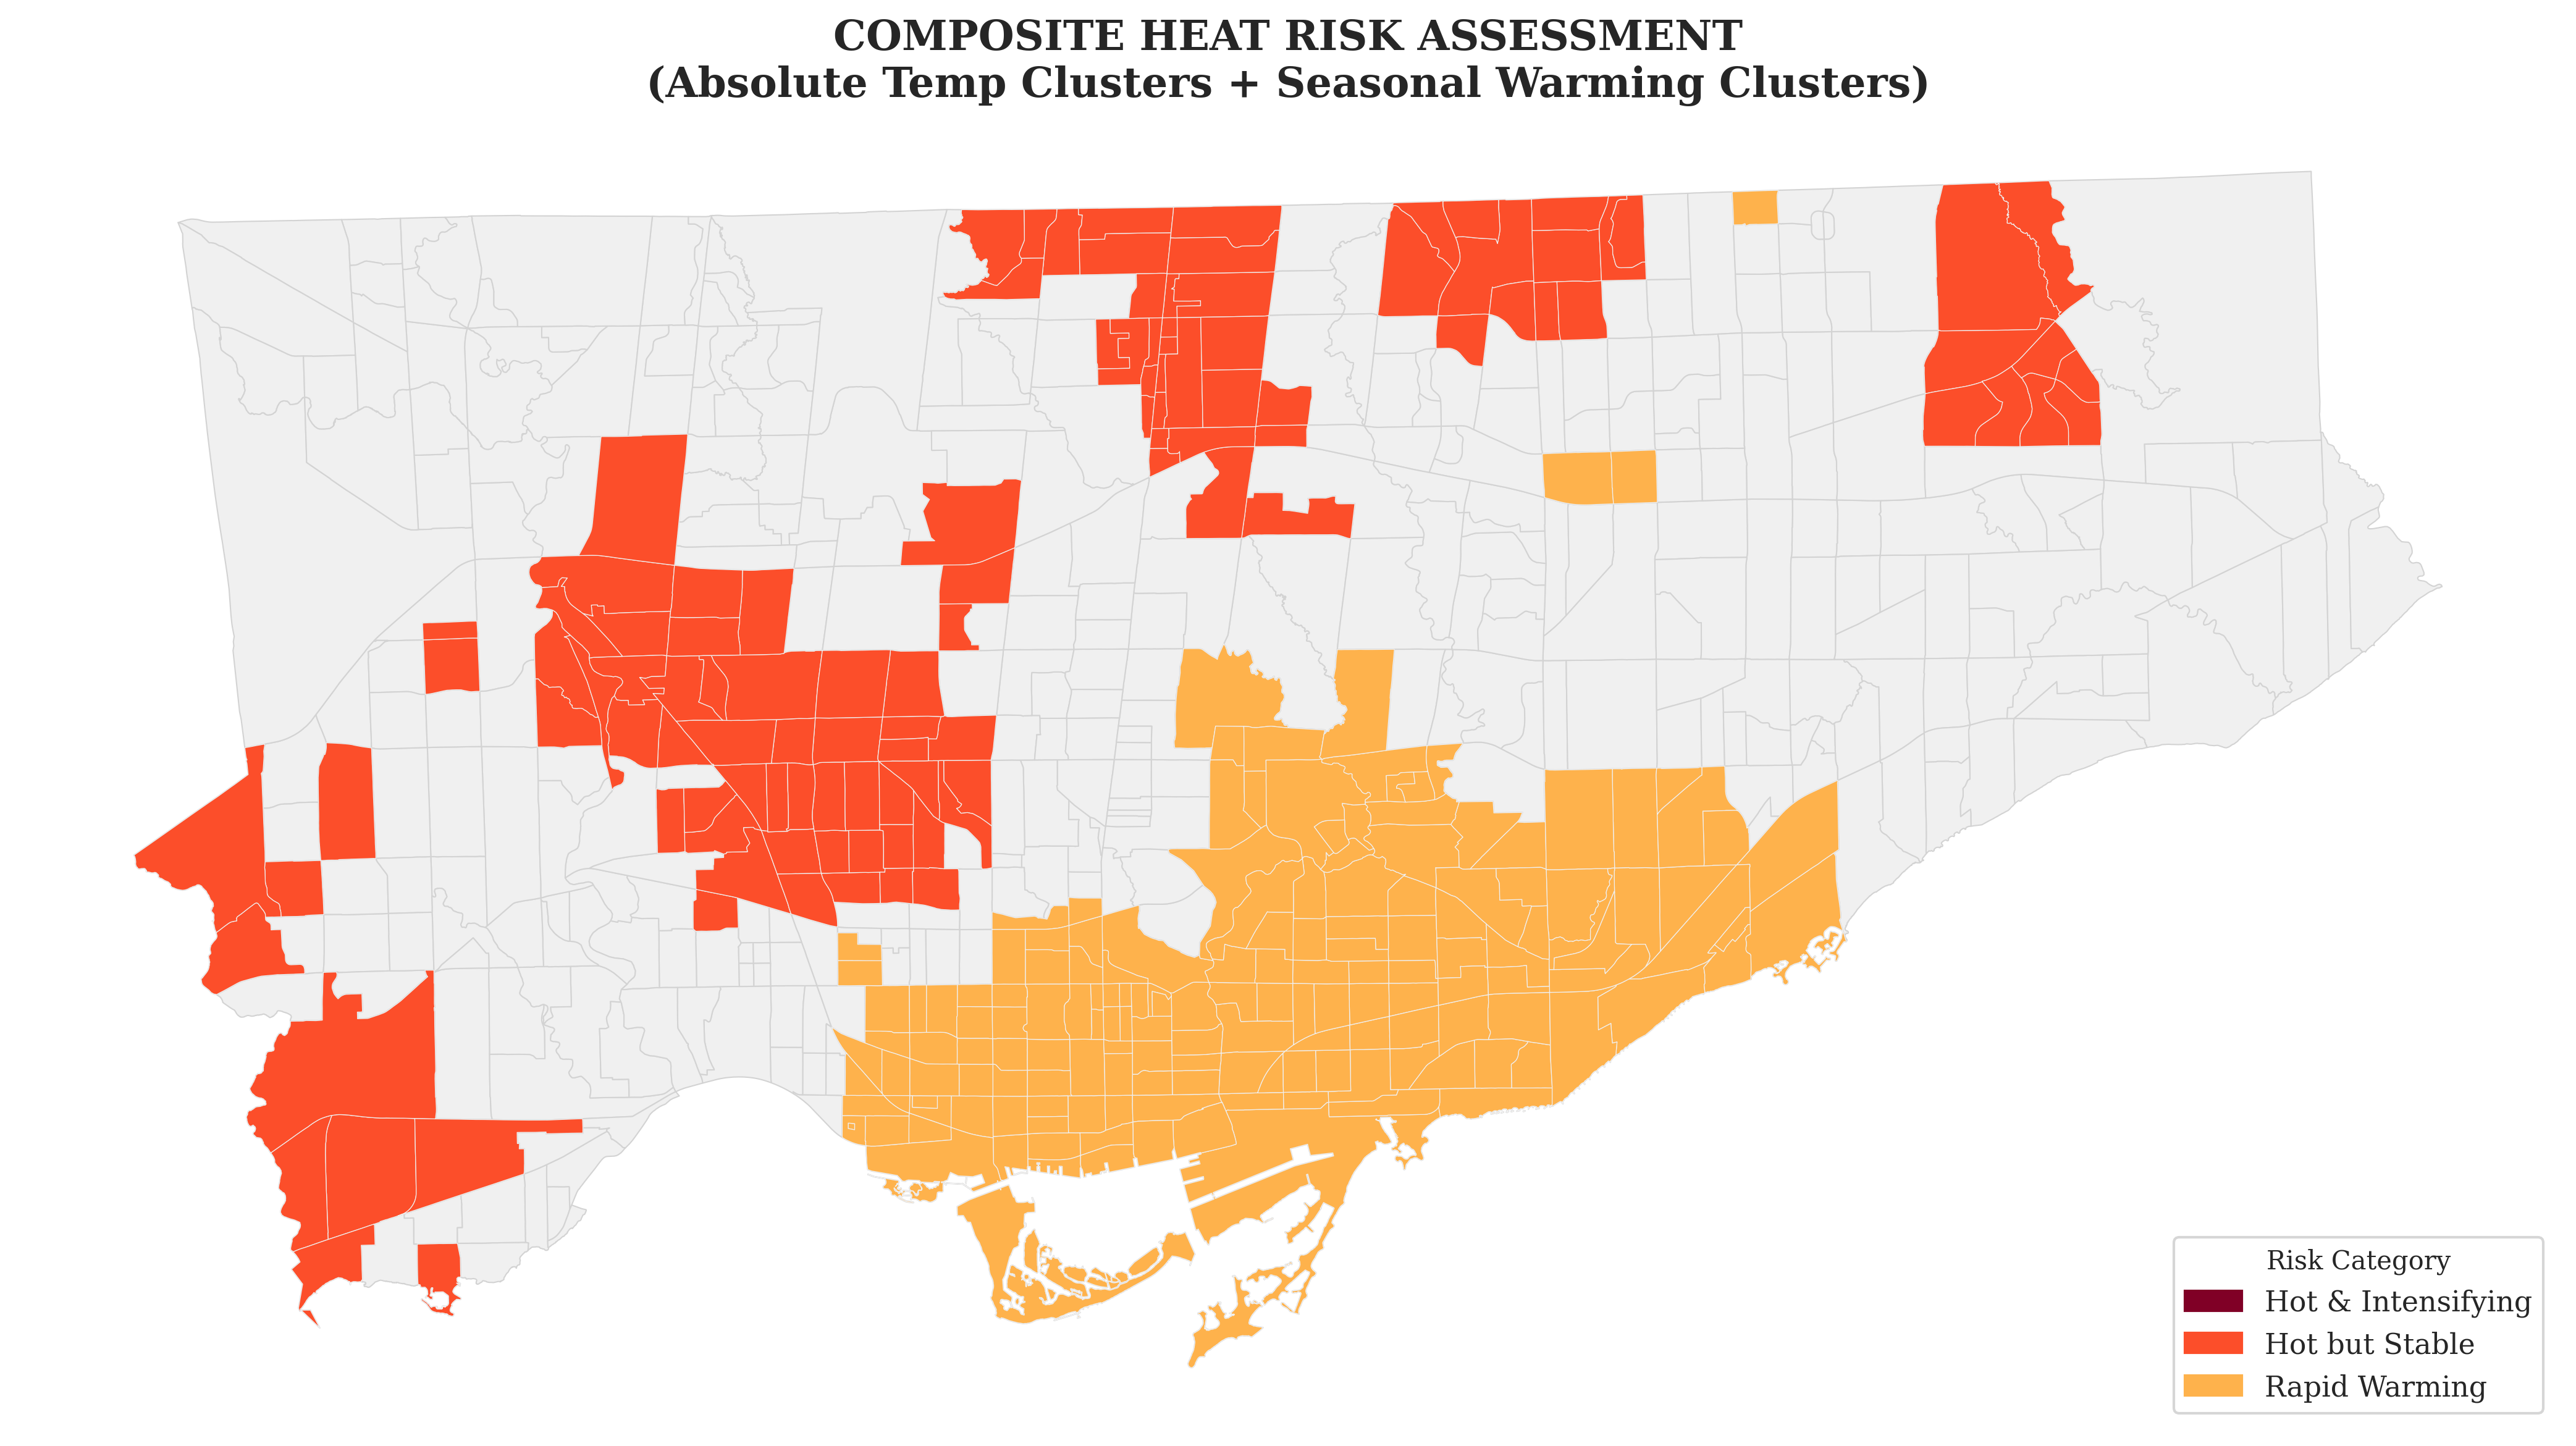

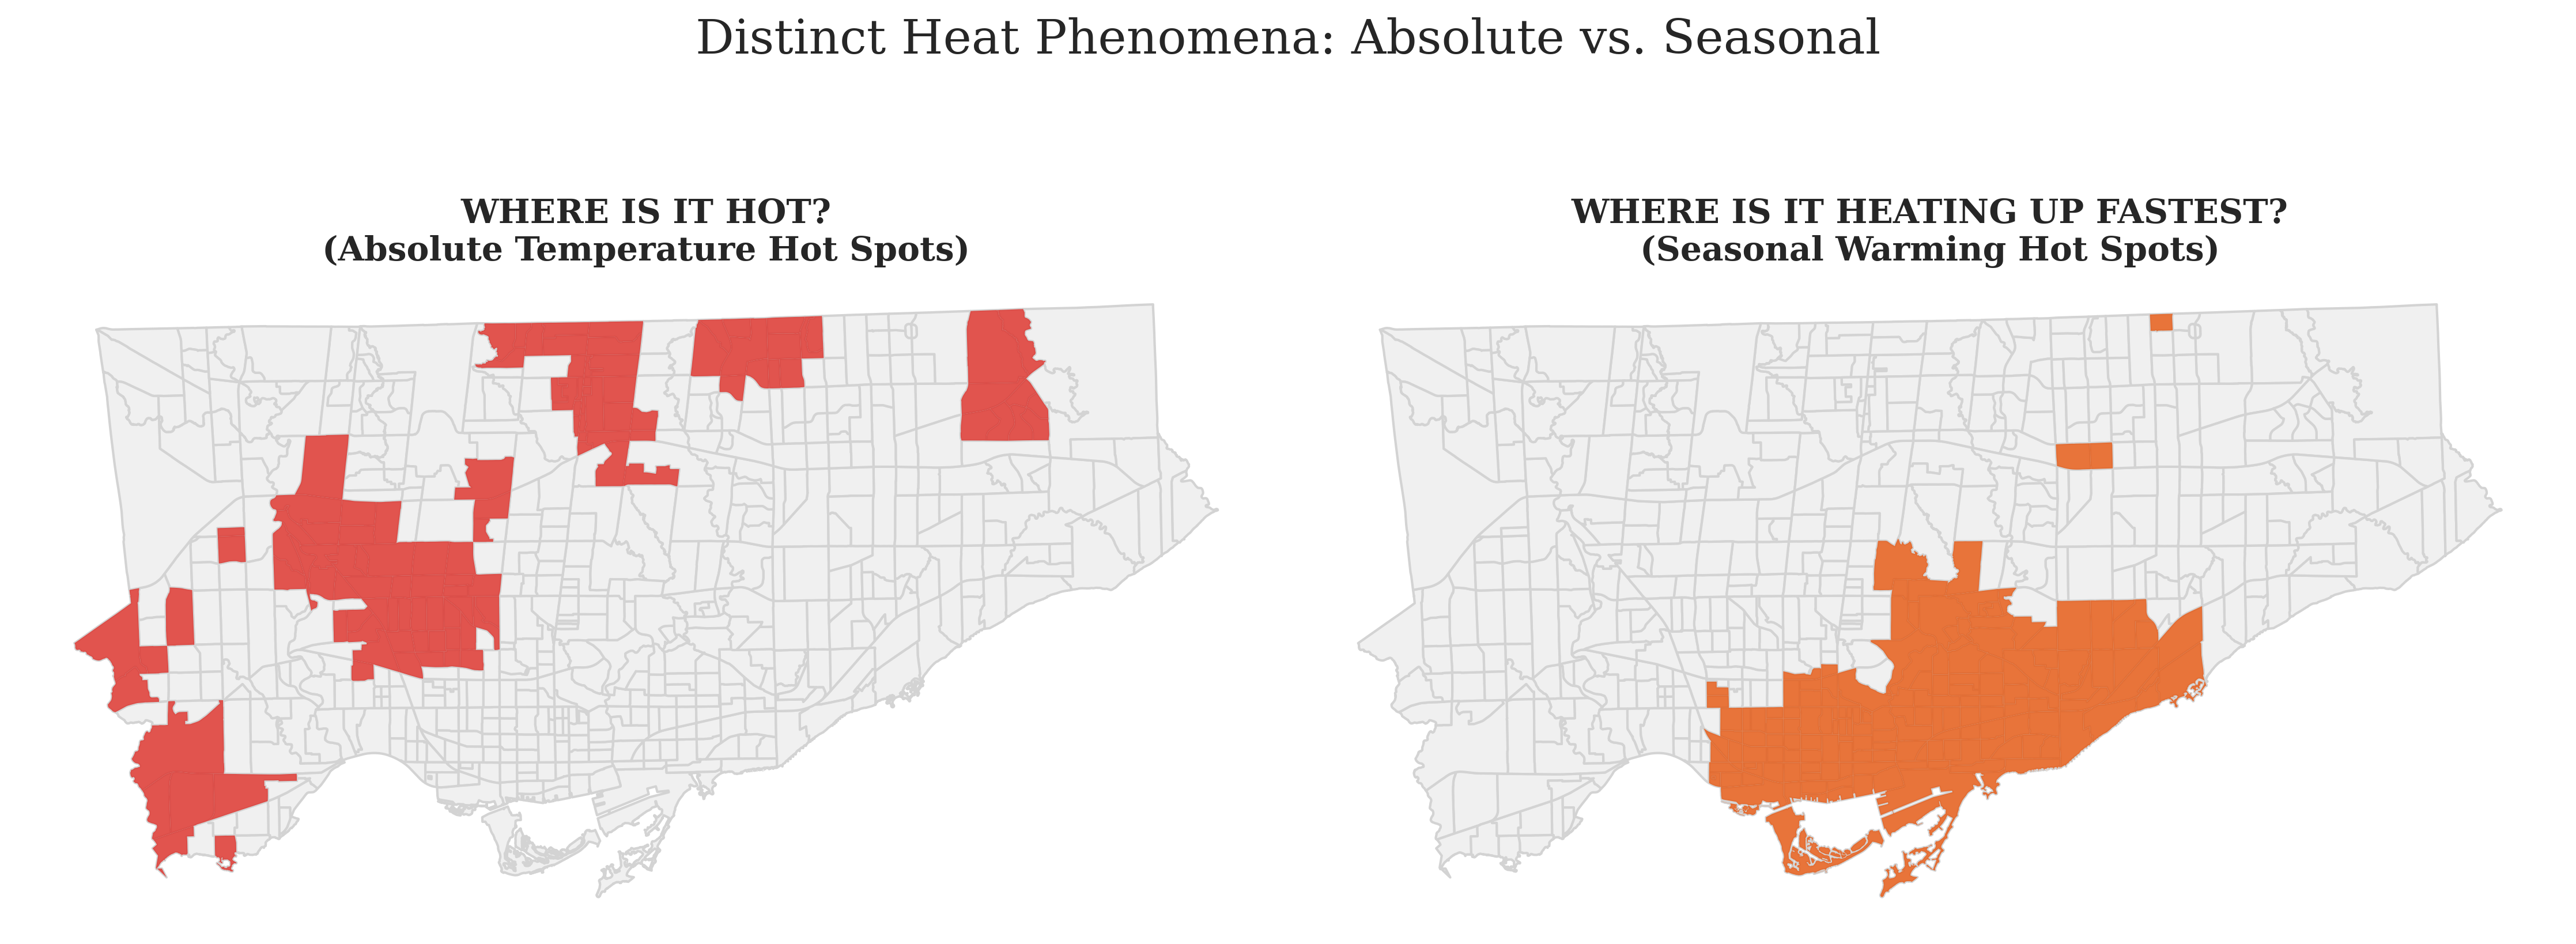

In [ ]:
# --- VISUALIZATION OF HOT SPOTS & RISK CATEGORIES ---
# FONTS & SETTINGS
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 300
warnings.filterwarnings('ignore')

# Rotate the entire dataframe once so all plots align perfectly
gdf_rotated = rotated_geometry(gdf)

# Create subsets from the ROTATED dataframe
hot_spots_rotated = gdf_rotated[gdf_rotated['is_hotspot'] == True]
risk_map_rotated = gdf_rotated[gdf_rotated['risk_category'] != 'Low Risk']
warming_hotspots_rotated = gdf_rotated[gdf_rotated['is_warming_hotspot'] == True]

# --- PLOT 1: SIGNIFICANT HOT SPOTS (Colored by Temperature) ---
f, ax = plt.subplots(1, figsize=(14, 12))

# 1. Base Layer
gdf_rotated.plot(
    ax=ax, 
    color='#f0f0f0', 
    edgecolor='#d3d3d3', 
    linewidth=0.5
)

# 2. Focus Layer (Hot Spots Only)
hot_spots_rotated.plot(
    column='avg_sumr', 
    cmap='Reds', 
    legend=True,
    legend_kwds={
        "orientation": "horizontal", 
        "shrink": 0.4, 
        "pad": 0.05, 
        "label": "Avg Summer Temp (°C)"
    },
    ax=ax, 
    edgecolor='black', 
    linewidth=0.5
)

ax.set_title(
    f"Toronto Urban Heat Islands\n(Significant Hot Spots, 95% Confidence)", 
    fontsize=16, 
    fontweight='bold'
)
ax.set_axis_off()

plt.tight_layout()
plt.show()

# --- PLOT 2: SIGNIFICANT HOT SPOTS ---
f, ax = plt.subplots(1, figsize=(14, 12))

# Base Layer (Light Grey Context) 
gdf_rotated.plot(ax=ax, color='#f0f0f0', edgecolor='#d3d3d3', linewidth=0.5)

# Focus Layer (Hot Spots Only) 
hot_spots_rotated.plot(column='Z_Score', 
               cmap='YlOrRd', 
               scheme='quantiles', 
               k=5, 
               legend=True,
               ax=ax, 
               edgecolor='black', 
               linewidth=0.5)

ax.set_title(f"ISOLATED URBAN HEAT ISLAND CLUSTERS\n(Significant Hot Spots, 95% Confidence)", fontsize=16, fontweight='bold')
ax.set_axis_off()


plt.tight_layout()
plt.show()


# --- PLOT 3: COMPOSITE RISK MAP ---

# Manual Color Map for Risk Categories
risk_colors = {
    'Hot & Intensifying': '#800026',  # Deep Dark Red
    'Hot but Stable': '#fc4e2a',       # Standard Orange-Red
    'Rapid Warming': '#feb24c'        # Yellow-Orange
}

f, ax = plt.subplots(1, figsize=(14, 12))

# Base Layer - Rotated
gdf_rotated.plot(ax=ax, color='#f0f0f0', edgecolor='#d3d3d3', linewidth=0.5)

# Plot Categories using rotated data
for cat, color in risk_colors.items():
    subset = risk_map_rotated[risk_map_rotated['risk_category'] == cat]
    if not subset.empty:
        subset.plot(ax=ax, color=color, edgecolor='#f0f0f0', linewidth=0.3, label=cat)

ax.set_title("COMPOSITE HEAT RISK ASSESSMENT\n(Absolute Temp Clusters + Seasonal Warming Clusters)", fontsize=16, fontweight='bold')
ax.set_axis_off()

# Custom Legend
patches = [mpatches.Patch(color=color, label=label) for label, color in risk_colors.items()]
plt.legend(handles=patches, loc='lower right', title="Risk Category", fontsize=11, frameon=True)

plt.tight_layout()
plt.show()


# --- PLOT 4: SIDE BY SIDE COMPARISON ---

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Map 1: Absolute Temperature
gdf_rotated.plot(ax=ax1, color='#f0f0f0', edgecolor='#d3d3d3')
hot_spots_rotated.plot(ax=ax1, color='#de2d26', alpha=0.8)
ax1.set_title("WHERE IS IT HOT?\n(Absolute Temperature Hot Spots)", fontsize=14, fontweight='bold')
ax1.set_axis_off()

# Map 2: Warming Rate
gdf_rotated.plot(ax=ax2, color='#f0f0f0', edgecolor='#d3d3d3')
warming_hotspots_rotated.plot(ax=ax2, color='#e6550d', alpha=0.8)
ax2.set_title("WHERE IS IT HEATING UP FASTEST?\n(Seasonal Warming Hot Spots)", fontsize=14, fontweight='bold')
ax2.set_axis_off()

plt.suptitle("Distinct Heat Phenomena: Absolute vs. Seasonal", fontsize=20)
plt.tight_layout()
plt.subplots_adjust(top=1.27)
plt.show()

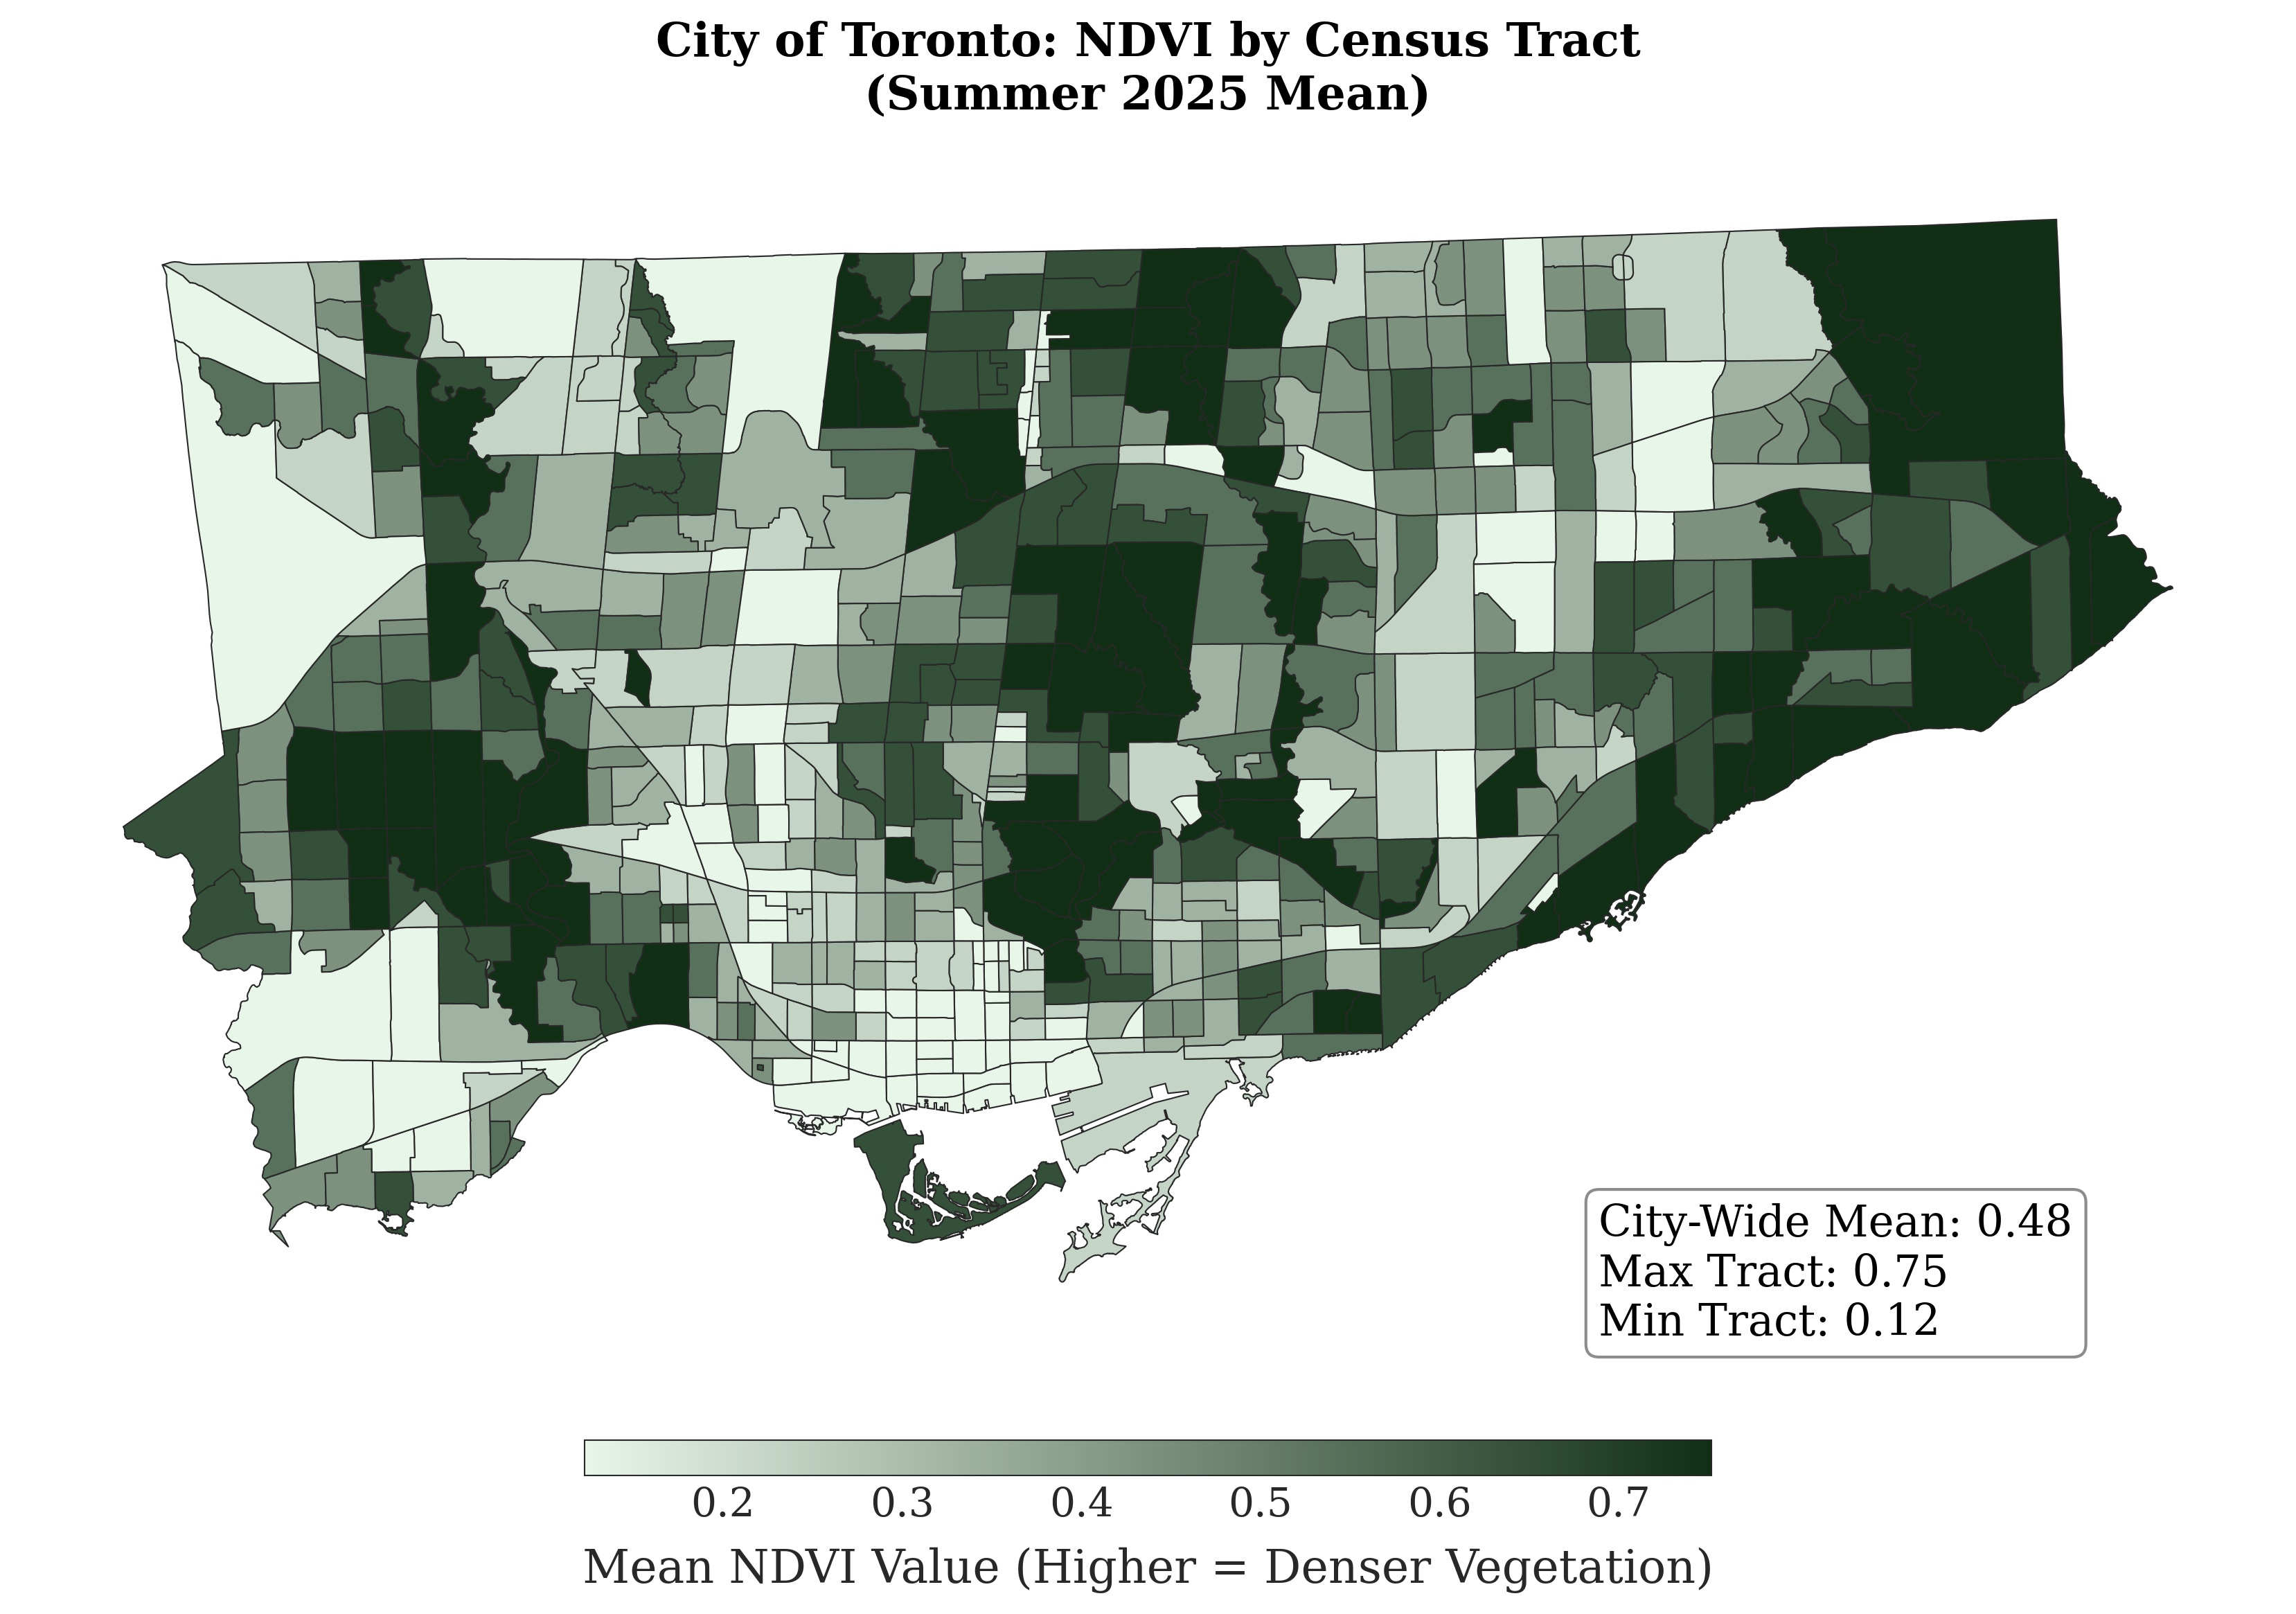

In [36]:
# --- NDVI ACROSS CENSUS TRACTS ---

gdf_rotated = rotated_geometry(gdf)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.titleweight'] = 'bold'

fig, ax = plt.subplots(1, figsize=(14, 12))

# Custom colormap
pale_green = '#E8F5E9'
deep_green = '#102f15'
cmap_name = colors.LinearSegmentedColormap.from_list('custom_greens', [pale_green, deep_green])

# PLOT THE MAP
gdf_rotated.plot(
    column='ndvi_mean',
    cmap=cmap_name,
    scheme='quantiles',
    k=7,
    ax=ax,
    edgecolor="#282828",
    linewidth=0.5,
    legend=False
)

# Clean up axes
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_axis_off()

# Title
ax.set_title(
    "City of Toronto: NDVI by Census Tract\n(Summer 2025 Mean)",
    fontsize=16,
    color='#000',
    pad=20
)

# --- COLORBAR (inset) ---
vmin = gdf_rotated['ndvi_mean'].min()
vmax = gdf_rotated['ndvi_mean'].max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap_name, norm=norm)
sm._A = []

cax = inset_axes(
    ax,
    width="50%",     # colorbar width relative to map width
    height="3%",     # colorbar height relative to map height
    loc='lower center',
    bbox_to_anchor=(0, -0.12, 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0
)

cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label(
    'Mean NDVI Value (Higher = Denser Vegetation)',
    fontsize=16,
    labelpad=8,
    color='#282828'
)
cbar.ax.tick_params(labelsize=14, colors='#282828')
cbar.outline.set_linewidth(0.5)
cbar.outline.set_edgecolor('#282828')

# Stats box
stats_text = (
    f"City-Wide Mean: {gdf['ndvi_mean'].mean():.2f}\n"
    f"Max Tract: {gdf['ndvi_mean'].max():.2f}\n"
    f"Min Tract: {gdf['ndvi_mean'].min():.2f}"
)

plt.text(
    0.70, 0.0,
    stats_text,
    transform=ax.transAxes,
    fontsize=15,
    color='#000',
    bbox=dict(facecolor='white', alpha=0.9, edgecolor='gray', boxstyle='round,pad=0.3')
)

plt.savefig('figures/ndvi_tract.png', dpi=300, bbox_inches='tight')
plt.show()

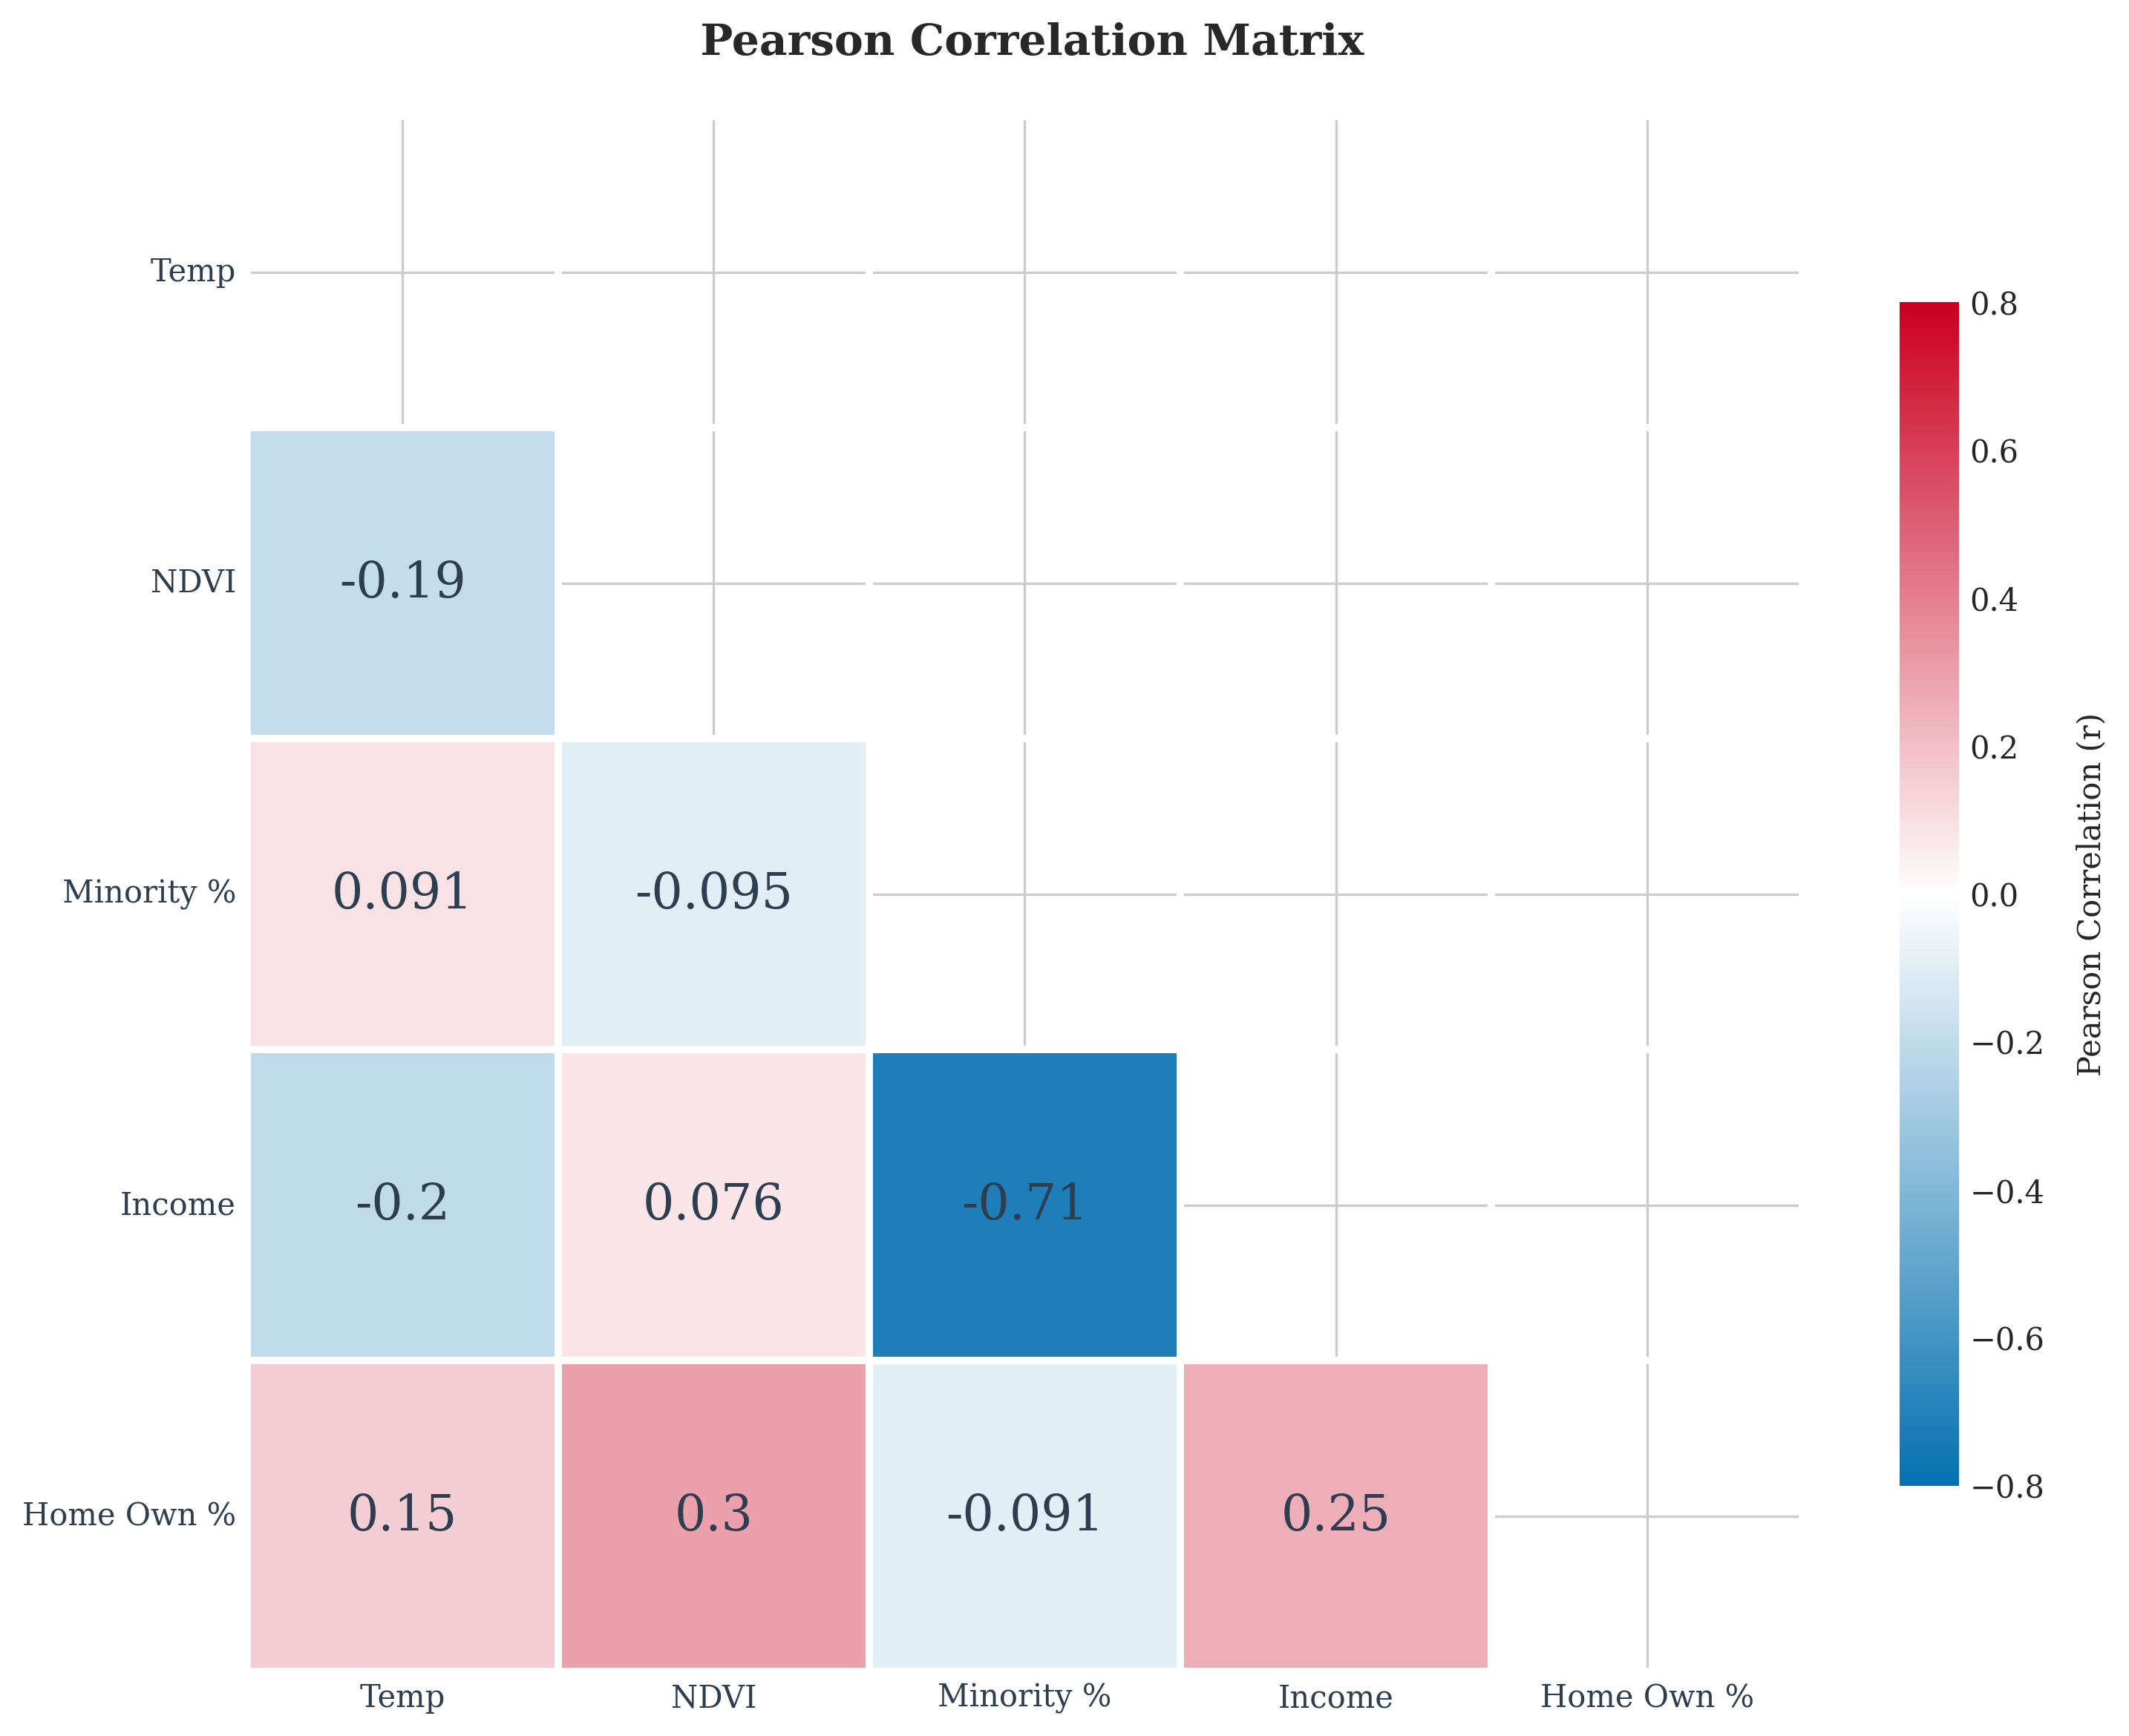

In [37]:
# --- CORRELATION MATRIX PLOT ---
# SETUP STYLE
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.titleweight'] = 'bold'

cols_for_corr = ['avg_sumr', 'ndvi_mean', 'minority_percent', 'INCOME', 'home_ownership_rate']
gdf_clean = gdf.dropna(subset=cols_for_corr) 
corr_matrix = gdf_clean[cols_for_corr].corr(method='pearson')

# short names
clean_names = {
    'avg_sumr': 'Temp',
    'ndvi_mean': 'NDVI',
    'minority_percent': 'Minority %',
    'INCOME': 'Income',
    'home_ownership_rate': 'Home Own %'
}
corr_matrix = corr_matrix.rename(index=clean_names, columns=clean_names)

colors = ["#0571b0", "#ffffff", "#ca0020"] 
custom_cmap = LinearSegmentedColormap.from_list("vibrant_diverging", colors)

# PLOT
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(10, 8))

ax = sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap=custom_cmap,
    vmin=-0.8, vmax=0.8,
    center=0,
    square=True,
    annot=True,
    fmt=".2g", 
    
    annot_kws={"fontsize": 16, "fontfamily": "serif", "weight": "medium", "color": "#2c3e50"},
    linewidths=2,
    linecolor='white',
    cbar_kws={"shrink": 0.75}
)

#  FORMATTING
plt.xticks(rotation=0, fontsize=10, fontfamily='serif', color='#2c3e50')
plt.yticks(rotation=0, fontsize=10, fontfamily='serif', color='#2c3e50')

plt.title(" Pearson Correlation Matrix", 
          fontsize=14, pad=20, color='#282828')

cbar = ax.collections[0].colorbar
cbar.set_label('Pearson Correlation (r)', fontsize=10, labelpad=10)
cbar.outline.set_linewidth(0)

plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=400, bbox_inches='tight')
plt.show()

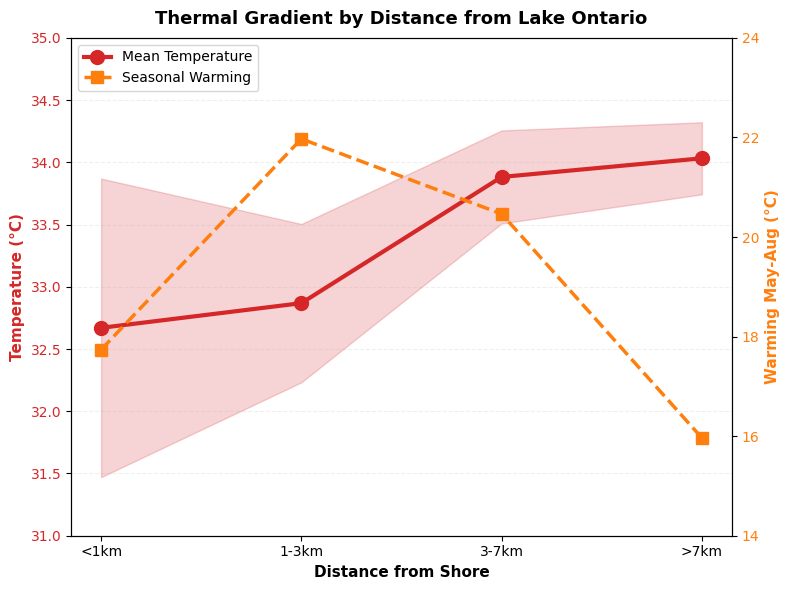

In [ ]:

# TEMPERATURE GRADIENT LINE PLOT

# lOAD DATA
gdf = gpd.read_file(join("shapefiles", "Toronto_ct", "Census_full.gpkg"))
city_boundary = gdf.geometry.union_all()
minx, miny, maxx, maxy = city_boundary.bounds
south_cutoff = miny + (maxy - miny) * 0.20 
southern_box = box(minx, miny, maxx, south_cutoff)
shoreline_geometry = city_boundary.boundary.intersection(southern_box)

# Calculate distances to shoreline
gdf_proj = gdf.to_crs(epsg=26917)
shoreline_proj = gpd.GeoSeries([shoreline_geometry], crs=gdf.crs).to_crs(epsg=26917)[0]
distances_meters = gdf_proj.geometry.centroid.distance(shoreline_proj)
gdf['dist_to_shore_km'] = distances_meters / 1000
gdf['shore_category'] = pd.cut(
    gdf['dist_to_shore_km'],
    bins=[0, 1, 3, 7, np.inf],
    labels=['<1km', '1-3km', '3-7km', '>7km']
)

# plotting setup
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate means and std errors
distance_bins = ['<1km', '1-3km', '3-7km', '>7km']
temp_means = []
temp_sems = []
warming_means = []

for cat in distance_bins:
    subset = gdf[gdf['shore_category'] == cat]
    temp_means.append(subset['avg_sumr'].mean())
    temp_sems.append(subset['avg_sumr'].sem())
    warming_means.append(subset['warming'].mean())

x_pos = np.arange(len(distance_bins))

# Temperature line
line1 = ax.plot(x_pos, temp_means, 'o-', color='#d62728', linewidth=3, 
                markersize=10, label='Mean Temperature', zorder=3)
ax.fill_between(x_pos, 
                np.array(temp_means) - np.array(temp_sems)*1.96,
                np.array(temp_means) + np.array(temp_sems)*1.96,
                alpha=0.2, color='#d62728')

ax.set_ylabel('Temperature (°C)', fontsize=11, fontweight='bold', color='#d62728')
ax.tick_params(axis='y', labelcolor='#d62728')
ax.set_ylim(31, 35)

# Warming line (secondary y-axis)
ax_twin = ax.twinx()
line2 = ax_twin.plot(x_pos, warming_means, 's--', color='#ff7f0e', linewidth=2.5,
                     markersize=8, label='Seasonal Warming', zorder=2)
ax_twin.set_ylabel('Warming May-Aug (°C)', fontsize=11, fontweight='bold', color='#ff7f0e')
ax_twin.tick_params(axis='y', labelcolor='#ff7f0e')
ax_twin.set_ylim(14, 24)

ax.set_xticks(x_pos)
ax.set_xticklabels(distance_bins, fontsize=10)
ax.set_xlabel('Distance from Shore', fontsize=11, fontweight='bold')
ax.set_title('Thermal Gradient by Distance from Lake Ontario', fontsize=13, fontweight='bold', pad=10)
ax.grid(axis='y', alpha=0.2, linestyle='--')

# Combined legend
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax.legend(lines, labels, loc='upper left', fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig('figures/lake_effect_gradient.png', dpi=300, bbox_inches='tight')
plt.show()


In [38]:
'''
This cell prepares the final data for web export
'''
gdf = gpd.read_file(join("shapefiles", "Toronto_ct", "Census_full.gpkg"))
gdf['temp_CV'] = (gdf['temp_august_std'] / gdf['t_aug']) * 100  #copied this from above

#  EXPORTT TO GEOJSON FOR WEB MAPPING
out_columns = [
    'CTUID', 
    'avg_sumr',          
    'ndvi_mean',         
    'warming',           
    'temp_CV',           
    'Z_Score',           
    'risk_category',     
    'minority_percent', 
    'INCOME', 
    'POPULATION',        
    'POPDEN',            
    'RENTER',            
    'OWNER',             
    'geometry',
]

web_gdf = gdf[out_columns].to_crs(epsg=4326)
fill_values = {'INCOME': 0, 'minority_percent': 0, 'Z_Score': 0, 'temp_CV': 0, 'POPULATION': 0, 'POPDEN': 0, 'RENTER': 0, 'OWNER': 0} # <-- ADDED fill values
web_gdf = web_gdf.fillna(fill_values)

output_file = "toronto_heat_data.js"
with open(output_file, "w") as f:
    f.write("const censusData = ")
    f.write(web_gdf.to_json())

web_gdf = gdf[out_columns].to_crs(epsg=4326)
fill_values = {'INCOME': 0, 'minority_percent': 0, 'Z_Score': 0, 'temp_CV': 0}
web_gdf = web_gdf.fillna(fill_values)

output_file = "toronto_heat_data.js"
with open(output_file, "w") as f:
    f.write("const censusData = ")
    f.write(web_gdf.to_json())

In [40]:
''' THIS OPENS THE WEB MAP IN BROWSER '''
import webbrowser
webbrowser.open("index.htm")

True

<div style="text-align:center;">
    
### <font color='#A7C080'>END OF NOTEBOOK</font>

</div>